<h1 style="color:SteelBlue; font-size:200%">Прогноз успешности компьютерных игр</h1>


Задача: выявить закономерности, определяющие успешность компьютерной игры.

Цель: Планирование рекламных кампаний для магазина компьютерных игр. Магазин работает по всему миру.

Из открытых источников собраны данные о продажах игр, к какому жанру они принадлежат и на каких платформах выпущены, рейтинге, оценках пользователей и экспертов. Данные - до 2016 года. Необходимо сделать прогноз продаж на 2017 год.

**Предварительные гипотезы:**

На успешность компьютерной игры (на её продаваемость) могут влиять объективные и субъективные факторы. Из представленных в наборе данных можно выделить:

- популярность жанра и платформы в регионе (определяется объёмами продаж, средними и суммарными, объективный фактор)
- возрастной рейтинг игры (объективный фактор)
- качество игры (определяется оценками пользователей и критиков, субъективный фактор)

Популярность жанра и платформы можно определить по объёму выпуска и продаж игр в регионе. Возрастной рейтинг присваивается организацией ESRB, качество игры можно оценить по оценкам пользователей и критиков.

Как выделить "идеальные" игры для продвижения в следующем году? 
- нужно определить, данные за какой период подходят для построения прогноза. Для этого нужно разобраться в тенденциях рынка, выяснить, сколько "живут" игровые платформы и когда происходили резкие изменения рынка
- выяснить, есть ли разница по продажам игр в разных регионах (меняются ли объёмы продаж по регионам одинаково или нет)
- определить популярные жанры и платформы в мире и регионах, т.е. те, для которых объём выпуска и продаж игр выше; определить тенденции
- выяснить, какие из этих популярных платформ и жанров больше нравятся пользователям и есть ли связь между оценками пользователей и критиков и объёмами продаж игры

**План:**
- разведочный анализ данных
    - просмотр датасета и общей информации, выявление проблем
    - анализ: за какое время доступны данные, какие платформы и жанры представлены, насколько полное это представление


- очистка и дополнение данных, исправление ошибок
    - очистка дублей
    - замена типов
    - анализ/заполнение пропусков
    - исправление ошибок


- подготовка данных для анализа
    - выбор актуального временного промежутка
    - досчёт показателей
    - подготовка датасета
    

- анализ популярных жанров и платформ
    
    - выбор популярных жанров и платформ - общемировой анализ
    - выбор популярных жанров и платформ - анализ в различающихся регионах, сравнение рынков


- анализ предпочтений пользователей
    - выбор любимых жанров и платформ, анализ связзей рейтингов и продаж


- анализ связи рейтинга ESRB с объёмами продаж игр


- общий вывод

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from scipy import stats
sns.set(style="whitegrid")

In [2]:
#функция построения диаграммы количества пропущенных значений
def NaN_estimation_graph(df, figsize=(8,6)):
    NaN_percent = (100*df.isna().sum()/len(df)).sort_values()
    colors = (NaN_percent  / NaN_percent.max()).tolist()
    colors = [(color, 0.5*(1-color), 0.5*(1-color)) for color in colors] #подготовка градиентной окраски
    plt.figure(figsize=figsize)
    plt.grid(alpha=0.8)
    plt.xticks(range(0,110,10))
    plt.xlim(0,NaN_percent.max()+20)
    plt.xlabel('% пропущенных значений')
    plt.ylabel('признак')
    xpos = NaN_percent + NaN_percent.max()*0.02

    for x, y, txt in zip(xpos, NaN_percent.index, df.isna().sum().sort_values()):
        plt.text(x, y, f'{txt} шт.', verticalalignment='center',
                bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.8)))
    plt.hlines(y=NaN_percent.index, xmin = 0, xmax = NaN_percent, alpha=0.7, 
               linewidth=10, colors=colors)
    plt.suptitle(f'Оценка количества и доли (%) пропусков в данных\nВсего записей: {len(df)}, из них с пропусками:')
    plt.show()

In [3]:
#функция построения диаграммы времени жизни платформ
def platform_lifetime_graph(df, figsize=(8,8)):
    plt.figure(figsize=figsize)
    index = df.groupby('platform')['year_of_release'].min().index
    life_start = df.groupby('platform')['year_of_release'].min()
    life_end = df.groupby('platform')['year_of_release'].max()
    colors = ['r' if x < 2016 else 'g' for x in life_end]
    plt.hlines(y=index, xmin = life_start, xmax = life_end, alpha=0.7, 
               linewidth=10, colors=colors)
    plt.suptitle('Время жизни игровых платформ: от года выпуска первой игры до года выпуска последней')
    plt.show()

In [4]:
#функция построения горизонтального барплота для платформ/жанров/отдельных игр
#с суммарным или средним объёмом продаж или количеством наименований игр
#проданных в заданном регионе за заданный период времени
def estimation_graph(df, figsize=(8,6), estimator='sum', region='global_sales', groupby='platform'):  
    
    if estimator == 'mean' or estimator == 'median':
        ci=95
    else:
        ci=None
   
    reg_dict = {'global_sales': 'Весь мир',
                'not_jp_sales': 'Весь мир, кроме Японии',
                'jp_sales': 'Япония',
                'eu_sales': 'Европа',
                'na_sales': 'Северная Америка',
                'other_sales': 'другое'
                }
    
    title_dict = {'mean': 'среднему объёму продаж одной игры (млн. $)',
                  'median': 'медианному объёму продаж одной игры (млн. $)',
                  'sum': 'суммарному объёму продаж игр (млн. $)',
                  'count': 'количеству наименований игр'}
    
    groupby_dict = {'platform': 'игровых платформ',
                   'genre': 'жанров',
                   'name':'игр'}
    
    color_dict = {'platform': 'c',
                 'genre': 'g',
                 'name': 'r'}
    
    
    estimator_dict = {'sum': np.sum,
                     'mean': np.mean,
                     'median': np.median,
                     'count': len}
    
    xlabel_dict = {'mean': 'объём продаж (млн. $)',
                   'median': 'объём продаж (млн. $)',
                   'sum': 'объём продаж (млн. $)',
                   'count': 'количество наименований игр, шт.'}
    
    period = f'{df["year_of_release"].min()} - {df["year_of_release"].max()}'
    
    title_str = f'Рейтинг {groupby_dict[groupby]} по {title_dict[estimator]}\nРегион: {reg_dict[region]}, {period}'
    
    if estimator == 'sum':
        sorted_list = df.groupby(groupby)[region].sum().sort_values(ascending=False).head(20)
    elif estimator == 'mean':
        sorted_list = df.groupby(groupby)[region].mean().sort_values(ascending=False).head(20)
    elif estimator == 'median':
        sorted_list = df.groupby(groupby)[region].median().sort_values(ascending=False).head(20)
    elif estimator == 'count':
        sorted_list = df.groupby(groupby)[region].count().sort_values(ascending=False).head(20)    
    
    sorted_list_indexes = [sorted_list.index.tolist().index(elem) for elem in sorted_list.index.tolist()]
         
    
    plt.figure(figsize=figsize)
    plt.grid(alpha=0.5)


    sns.barplot(y=groupby, x=region, 
                estimator=estimator_dict[estimator], 
                color=color_dict[groupby], edgecolor=".5", alpha=0.7, 
                ci=ci, capsize=0.2, errwidth=1,
                order=sorted_list.index, data=df)  
    xpos = sorted_list.values + sorted_list.values.max()*0.02

    for x, y, txt in zip(xpos, sorted_list_indexes, sorted_list.values):
        hral = 'left'
        if estimator == 'mean' or estimator == 'median':
            hral = 'center'
            y+=0.5
            text = f'{round(txt,2)}'
        elif estimator == 'sum':
            text = f'{round(txt,1)}'
        elif estimator == 'count':
            text = f'{txt}'

        plt.text(x, y, text, horizontalalignment=hral, verticalalignment='center',
                    bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.5)))

    plt.xlabel(xlabel_dict[estimator])
    plt.suptitle(title_str)
    plt.ylabel('')
    plt.show()

In [5]:
#функция построения датафрейма со средними и их стандартными ошибками
def means_with_errors(df, groupby='genre', region='global_sales'):
    std = df.groupby(groupby)[region].std()
    count = df.groupby(groupby)[region].count()
    std_mean = (std / np.sqrt(count)).reset_index().round(3)
    mean = df.groupby(groupby)[region].mean().reset_index().round(3)
    df = mean.merge(std_mean, 
                      how='outer', 
                      on=groupby, 
                      suffixes=('_mean', '_mean_standard_error')).sort_values(by=f'{region}_mean', 
                                                                ascending=False).reset_index(drop=True)    
    #df.loc[:, f'{region}_mean'] = df.loc[:, f'{region}_mean'].astype(str) + ' +/- ' + df.loc[:, f'{region}_mean_error x 2'].astype(str)
    return df

In [6]:
#функция построения сборной таблицы и тепловой карты по этой таблице
#для оценки популярности пары платформа-жанр
#можно менять годы и параметр оценки (mean, sum, count)
def genres_platforms_heatmap(df, 
                             year=[2013, 2014, 2015, 2016], 
                             region='global_sales',
                             estimator='sum',
                             dropall=True,
                             vmax=None, pivot=False, figsize=(12,10)):
    
    df_year = df.loc[df.loc[:,'year_of_release'].isin(year), :]
    pivot_df = df_year.pivot_table(index='platform', 
                                   columns='genre', 
                                   values = region, 
                                   aggfunc = estimator, 
                                   margins=True).sort_values('All', ascending=True).sort_values('All', 
                                                                                                axis=1,
                                                                                                ascending=True)
    
    
    title_dict = {'mean': 'Средние объёмы продаж (млн. $)',
                  'sum': 'Суммарные объёмы продаж (млн. $)',
                  'count': 'Число выпущенных игр'}

    reg_dict = {'global_sales': 'весь мир',
                'not_jp_sales': 'весь мир, кроме Японии',
                'jp_sales': 'Япония',
                'eu_sales': 'Европа',
                'na_sales': 'Северная Америка',
                'other_sales': 'другое'
                }    
    
    year_str = ', '.join(str(yr) for yr in year)
    
    if dropall:
        pivot_df = pivot_df.drop(index=['All'], columns=['All'])
    
    if pivot:
        return pivot_df
    
    plt.figure(figsize=figsize)
    plt.suptitle(f'{title_dict[estimator]} по игровым платформам и жанрам\n{year_str} г.\nрегион: {reg_dict[region]}')
    sns.heatmap(pivot_df.round(2), vmin=0, vmax=vmax, annot=True, fmt='.4g', cmap='rainbow')
    plt.show()

In [7]:
#построение таблицы с суммарными и средними продажами игр в регионе
def games_sales_rating(df, year=[2013, 2013, 2014, 2015, 2016], values='global_sales'):
    df_year = df.loc[df.loc[:,'year_of_release'].isin(year), :]
    games_sales_rating_df = pd.DataFrame()
    games_sales_rating_df[f'{values}_sum'] = df_year.groupby(['platform', 'genre'])[values].sum().round(2)
    games_sales_rating_df[f'{values}_mean'] = df_year.groupby(['platform', 'genre'])[values].mean().round(2)
    games_sales_rating_df[f'{values}_count'] = df_year.groupby(['platform', 'genre'])[values].count()
    return games_sales_rating_df

In [8]:
#функция построения сборной таблицы и тепловой карты по этой таблице
#для оценки рейтинга пользователей и критиков для пары платформа-жанр
def scores_heatmap(df, values='critic_score', pivot=False, dropall=False, vmin=None, vmax=None):
    pivot_df = df.pivot_table(index='platform', 
                              columns='genre',
                              values = values, 
                              aggfunc = 'mean', 
                              margins=True)
    if dropall:
        pivot_df = pivot_df.drop(index=['All'], columns=['All'])
    
    if pivot:
        return pivot_df
    
    title_dict = {'critic_score':'критиков',
                  'user_score': 'пользователей'
                 }
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_df.round(2), vmin=vmin, vmax=vmax, annot=True, fmt='.4g', cmap='rainbow')
    plt.suptitle(f'Оценки {title_dict[values]} по платформам и жанрам')
    plt.tight_layout(rect=(0, 0, 0.95, 0.95))
    plt.show()

In [9]:
#перестановочные статистические тесты 
#написаны мной в другом проекте, поэтому комментарии на англ. языке
def AB_permutation_test(x, y, par='means', iterations=10000):   
    """
    This is a two-sided permutation test for the null hypothesis that 
    2 samples (x=A and y=B) have identical average values or median values 
    or variances.

    No assumption of the distribution's normality needed
    Samples can be of different sizes, independent or dependent.

    1. The test can be verified by a t-test for the means difference:
    
        scipy.stats.ttest_ind(x,y)
        pvalues should be approximately the same

        Note:
            - normal distributions needed for A, B
            - statistics are different, because 
            in t-test statistic = mean(x)-mean(y)/var(x-y) 
            and in this test statistic = abs(mean(x)-mean(y)) without var(x-y) 

    2. The test can be verified by a Fisher distribution for the variances 
    ratio:
    
        scipy.special.fdtrc(dfn, dfd, f)
        dfn = len(x) - 1
        dfd = len(y) - 1
        f = np.var(x) / np.var(y)
        statistics and pvalues should be approximately the same

        Notes: 
            - normal distributions needed for A, B

    Parameters
    ----------
    
    x : array_like
        A sample.
    
    y : array_like
        B sample.
    
    par : str, optional
        Type of test statistic:
        'means': the absolute difference between the means
        statistic = abs(mean(x) - mean(y))
        
        'medians': the absolute difference between the medians
        statistic = abs(median(x) - median(y))
        
        'variances': the ratio of the variances
        if var(x) > var(y)
        statistic = var(x) / var(y)
        if var(x) < var(y)
        statistic = var(y) / var(x)
        
        The default is 'means'.
    
    iterations : integer, optional
        Number of permutations. The default is 1000.

    Returns
    -------
    named tuple (statistic, iterations, pvalue).
    
    statistic: float
        The computed statistic of the test.
        
        'means_difference' = abs(mean(x) - mean(y))
        'medians_difference' = abs(median(x) - median(y))
        'variances_ratio' = var(x) / var(y)

    itertions: int
        Number of permutations  
        
    pvalue: float
        The two-tailed p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
   
    """
    k = 0
    size_a = len(x)
    a=np.asarray(x) 
    b=np.asarray(y)
    alldata = np.concatenate((a, b))
    
    if par == 'means':
        statistic = 'means_difference'
        diff = np.mean(a) - np.mean(b)
    elif par == 'medians':
        statistic = 'medians_difference'
        diff = np.median(a) - np.median(b)
    elif par == 'variances':
        statistic = 'variances_ratio'
        var_a = np.var(a, ddof=1)
        var_b = np.var(b, ddof=1)
        var_1 = max(var_a, var_b)
        var_2 = min(var_a, var_b)
        diff = var_1 / var_2
    else:
        return "ERROR. Incorrect 'par' value. Use par='means' or 'medians' or 'variances'."
    
    abs_diff = abs(diff)
  
    for i in range (0, iterations):
        np.random.shuffle(alldata) #перемешиваю
        if par == 'means':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'medians':
            abs_random_diff = abs( np.mean(alldata[:size_a]) - np.mean(alldata[size_a:]) )
        elif par == 'variances':
            abs_random_diff = np.var(alldata[:size_a], ddof=1) / np.var(alldata[size_a:], ddof=1)
        
        k += abs_diff < abs_random_diff
        
    pvalue = k / iterations
       
    ABPermutationResult = namedtuple('AB_PermutationResult', (statistic, 'iterations', 'pvalue'))
    
    return ABPermutationResult(diff, iterations, pvalue)


def ANOVA_permutation_test(*args, iterations=10000):
    
    """

    Parameters
    ----------
    *args : sample1, sample2, …: array_like
        The sample measurements for each group.

    iterations : integer, optional
        Number of permutations. The default is 10000.

    Returns
    -------
    
    statistic: float
        The computed F-value of the test.
        
    iterations : int
        Number of permutations.

    pvalue: float
        The associated p-value: number of times, when permutations statistics 
        were larger than the original, divided by the number of iterations
        
    """
    k = 0
    args = [np.asarray(arg) for arg in args]
    
    alldata = np.concatenate(args)
    mean_alldata = np.mean(alldata)
    
    n_groups = len(args)
    n_alldata = len(alldata)
    
    fbg = n_groups - 1
    fwg = n_alldata - n_groups
    
    SSbg = 0    
    SStotal = np.var(alldata)*n_alldata
    
    size_groups = []
    for arg in args:
        size_groups.append(len(arg))
        SSbg += len(arg)*(mean_alldata - np.mean(arg))**2
    
    SSwg = SStotal - SSbg

    F_orig = (SSbg/fbg) / (SSwg/fwg)
    
    for i in range(0, iterations):
        np.random.shuffle(alldata)
        size_previous = 0
        random_groups = []
        SSbg_random = 0
        
        for size_grp in size_groups:
            random_groups.append(alldata[size_previous : (size_grp+size_previous)])
            size_previous += size_grp
        
        for random_grp in random_groups:
            SSbg_random += len(random_grp)*(mean_alldata - np.mean(random_grp))**2
            
        
        SSwg_random = SStotal - SSbg_random
        F_random = (SSbg_random/fbg) / (SSwg_random/fwg)
        k += F_orig < F_random
    
    pvalue = k / iterations
    
    ANOVAPermutationResult = namedtuple('ANOVA_PermutationResult', ('f_statistic', 'iterations', 'pvalue'))
    
    return ANOVAPermutationResult(F_orig, iterations, pvalue) 

In [10]:
gen8_platform_list = ['PS4', 'XOne', 'WiiU', 'PC', '3DS', 'PSV']
platform_color_dict = {'PS4': 'xkcd:dark pink',
                       'PS3': 'xkcd:pink',
                       'XOne': 'xkcd:olive green',
                       'X360': 'xkcd:light green',
                       '3DS': 'xkcd:sky blue',
                       'WiiU': 'xkcd:orange',
                       'Wii': 'xkcd:gold',
                       'PC': 'xkcd:hot purple',
                       'PSV': 'xkcd:blue',
                       'PSP': 'black',
                       'DS': 'brown'
                      }
alpha = 0.05

<h1 style="color:SteelBlue"> 1. Разведочный анализ и подготовка данных</h1>

<h2 style="color:DodgerBlue">1.1 Общая информация</h2>

In [11]:
games_df = pd.read_csv('datasets/games.csv')

In [12]:
games_df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


**Описание данных:**


- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы долларов)
- EU_sales — продажи в Европе (миллионы долларов)
- JP_sales — продажи в Японии (миллионы долларов)
- Other_sales — продажи в других странах (миллионы долларов)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB

Похоже, что данные представляют собой результаты парсинга https://www.vgchartz.com или https://192-168-1-1pass.com/games/
И данные NA_sales, EU_sales и т.д. - это данные об объёмах продажи игры с даты релиза и до момента выгрузки базы (а не за год релиза). 

In [13]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


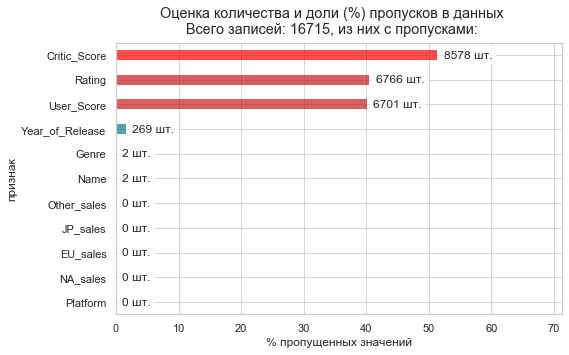

In [14]:
NaN_estimation_graph(games_df, figsize=(8,5))

В датасете 16715 записей, есть пропущенные значения. Основная доля пропусков приходится на оценки критиков и пользователей, а также - рейтинг ESRB. Типы данных не везде соответствуют ожидаемым, вероятно из-за пропусков/наличия нехарактерных значений. Названия столбцов содержат прописные и строчные буквы. Можно оставить так, но, на мой взгляд, удобнее привести к общему регистру.

<h2 style="color:DodgerBlue">1.2 Предварительная обработка данных: дубликаты и пропуски</h2>

Названия столбцов можно для удобства привести к нижнему регистру. Сделаю это.

In [15]:
games_df.columns = games_df.columns.str.lower()

### 1.2.1 Дубликаты

Проверю на полные дубли:

In [16]:
print('число полных дублей:', games_df.duplicated().sum())

число полных дублей: 0


Проверю на скрытые дубли. Выведу списки уникальных названий платформ, жанров и игр, посмотрю, есть ли повторы и проблемы. Названий игр очень много. Их приведу к нижнему регистру и провери полные дубли ещё раз.

In [17]:
print('платформы:', games_df['platform'].unique())
print('жанры:', games_df['genre'].unique())

платформы: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4' '3DS' 'N64'
 'PS' 'XB' 'PC' '2600' 'PSP' 'XOne' 'WiiU' 'GC' 'GEN' 'DC' 'PSV' 'SAT'
 'SCD' 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']
жанры: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting' 'Adventure' 'Strategy' nan]


In [18]:
games_df['name'] = games_df['name'].str.lower()
print('Полных дублей после приведения названий игр к одному регистру:', games_df.duplicated().sum())

Полных дублей после приведения названий игр к одному регистру: 0


**Полных и скрытых дублей в данных нет.**

### 1.2.2 Обработка пропущенных значений

In [19]:
print('пропуски в названии игры и жанра:')
games_df.loc[games_df.loc[:, 'genre'].isna(),:]

пропуски в названии игры и жанра:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Пропуски в названии игры и жанра - для двух игр, пропущены оба значения. Без этих признаков данные в конкретном исследовании бесполезны, удаляю.

In [20]:
games_df.dropna(subset=['name', 'genre'], inplace=True)
games_df.reset_index(drop=True, inplace=True)

In [21]:
print('Пропусков в годе выпуска игры:', games_df.loc[:, 'year_of_release'].isna().sum())

Пропусков в годе выпуска игры: 269


В названиях некоторых игр присутствует год выпуска. Можно его оттуда выделить. Посмотрю, он согласуется с датой выпуска игры? Например:

In [22]:
games_df.loc[games_df.loc[:, 'year_of_release'].isna(),:].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,madden nfl 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,fifa soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,lego batman: the videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe smackdown vs. raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,space invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Madden NFL 2004, Даты выпуска: [США - 12 августа 2003, ЕС - 12 сентября 2003 (GC, PC, PS2, Xbox)](https://ru.wikipedia.org/wiki/Madden_NFL_2004).  FIFA Soccer 2004: [октябрь 2003](https://ru.wikipedia.org/wiki/FIFA_Football_2004) не согласуется. Заполнять и проверять вручную 269 пропусков проблематично. Пропуски в годе выпуска составляют менее 2% данных, год выпуска важен для анализа, т.к. популярность игр разных жанров в разные годы может быть различной, предпочтения пользователей меняются. Исключу записи с пропусками в годе выпуска из рассмотрения.

In [23]:
games_df.dropna(subset=['year_of_release'], inplace=True)
games_df.reset_index(drop=True, inplace=True)

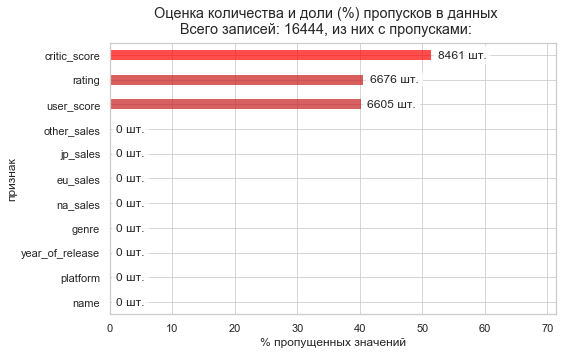

In [24]:
NaN_estimation_graph(games_df, figsize=(8,5))

Остались пропуски в рейтинге ESRB, оценках пользователей и критиков. Можно предположить, что этих данных нет, т.к. рейтинг и оценки не присваивались. Проверю предположение. Оценю, для каких годов выпуска характерно отсутствие рейтингов, нет ли каких-то аномалий на графиках.

In [25]:
games_df.loc[:, 'year_of_release'] = games_df.loc[:, 'year_of_release'].astype(int)

Анализ распределения отсутствующих оценок и рейтингов по годам


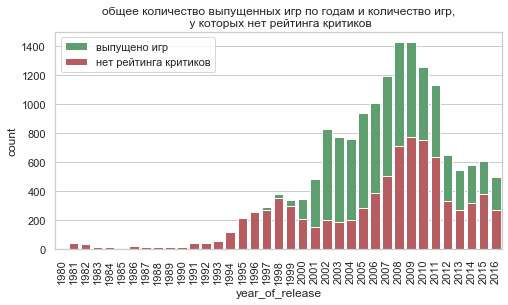

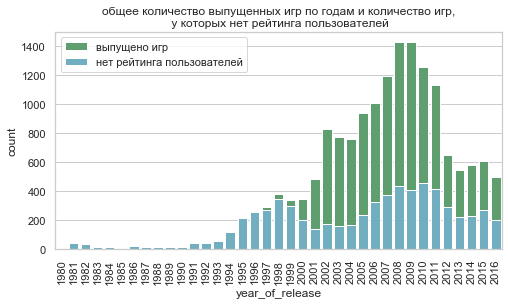

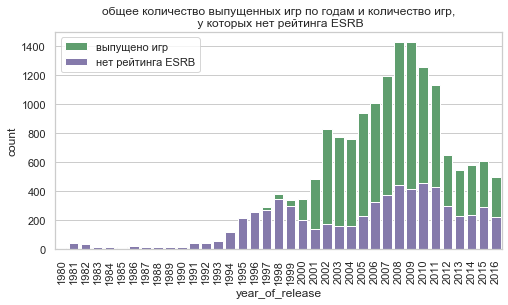

In [26]:
print('Анализ распределения отсутствующих оценок и рейтингов по годам')
for element, label, color in [('critic_score', 'нет рейтинга критиков', 'r'),
                       ('user_score', 'нет рейтинга пользователей', 'c'),
                       ('rating', 'нет рейтинга ESRB', 'm')]:
    plt.figure(figsize=(8, 4))
    ax = plt.subplot()
    ax.set_title(f'общее количество выпущенных игр по годам и количество игр,\n у которых {label}')
    sns.countplot(ax=ax, x='year_of_release', data = games_df, 
                  color = 'g', label='выпущено игр', alpha=1)
    sns.countplot(ax=ax, x='year_of_release', data = games_df.loc[games_df.loc[:, element].isna(),:], 
                  color = color, label=label, alpha=1)
    plt.legend()
    plt.xticks(rotation=90)
    plt.show()

Похоже, до 2000 года рейтиниги не присваивались. После 2000 г. примерно одинаковая доля игр каждый год оставалась без рейтинга. Для всех рейтингов динамика от года к году похожа и совпадает с динамикой выпуска игр. Аномалий на графиках не видно.

Заполню nan для признака rating значениями unknown. Это логично, т.к. тип данных строковый:

In [27]:
games_df.loc[:, 'rating'] = games_df['rating'].fillna('unknown')
print('уникальные значения рейтинга ESRB:', games_df['rating'].unique())

уникальные значения рейтинга ESRB: ['E' 'unknown' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


Чтобы было понятно, что из себя представляют рейтинги, заменю обозначения на [понятное описание](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)


- 'E': 'everyone'
- 'M': '17+'
- 'T': '13+'
- 'E10+': '10+'
- 'K-A': 'everyone'
- 'AO': '18+'
- 'EC': '3+' (изначально разрабатываются для детей и обычно представляют собой развивающие игры)
- 'RP': 'unknown' (продукт был отправлен в ESRB и ожидает присвоения рейтинга)

In [28]:
rating_dict = {'E': 'everyone',
               'M': '17+',
               'T': '13+',
               'E10+': '10+',
               'K-A': 'everyone',
               'AO': '18+',
               'EC': '3+',
               'RP': 'unknown' 
              }
games_df['rating'].replace(rating_dict, inplace=True)

In [29]:
print('уникальные значения рейтинга ESRB:', games_df['rating'].unique())

уникальные значения рейтинга ESRB: ['everyone' 'unknown' '17+' '13+' '10+' '18+' '3+']


In [30]:
print('уникальные значения оценки пользователей', games_df['user_score'].unique())

уникальные значения оценки пользователей ['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


Среди оценок пользователей присутствует 'tbd', что значит 'to be determined', будет определён (в дальнейшем). Из-за этого столбец признака имеет формат object. Чтобы было удобно работать с анализом (в том числе - корреляциями и столбчатыми диаграммами), заменю tbd на NaN и приведу данные к численному формату.

In [31]:
games_df.loc[games_df.loc[:, 'user_score'] == 'tbd', 'user_score'] = np.nan

In [32]:
games_df.loc[:, 'user_score'] = pd.to_numeric(games_df.loc[:, 'user_score'])
#for feature in ['genre', 'platform', 'rating']:
#    games_df.loc[:, feature] = games_df.loc[:, feature].astype('category')

<h2 style="color:DodgerBlue">Результаты предварительной обработки данных</h2>

После выполненных действий картина по пропускам следующая:

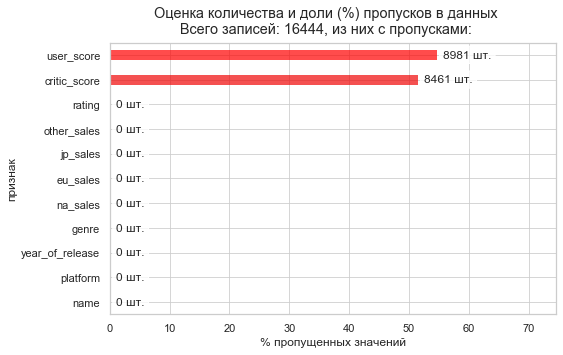

In [33]:
NaN_estimation_graph(games_df, figsize=(8,5))

In [34]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.3+ MB


После обработки пропусков данные имеют правильный тип. Пропуски в оценках пользователей и критиков заполнять медианой или средним не вижу смысла, т.к. это может привести к смещению данных. Можно заполнить нехарактерными значениями типа "-100", но не буду, чтобы не применять логические условия при построении диаграмм и расчёте корреляций. 

<h2 style="color:DodgerBlue">1.3 Расчёт недостающих признаков</h2>

Чтобы выяснить, какие игры продаются лучше и приносят больше прибыли, нужно посчитать суммарные объёмы продаж. Есть подозрение, что динамика продаж для разных регионов может быть разной. Возможно, есть смысл выделить какой-то регион.


Выполню оценочный корреляционный анализ, чтобы выяснить, есть ли связь между объёмами продаж в разных регионах. Использую непараметрический метод спирмена, т.к. на данном этапе нужна оценка и анализ вида распределений не проводился.

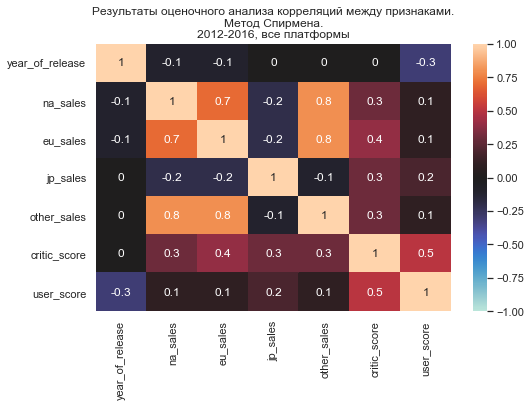

In [35]:
plt.figure(figsize=(8,6))
sns.heatmap(games_df.corr(method='spearman').round(1), center=0, vmin=-1, vmax=1, annot=True)
plt.title('Результаты оценочного анализа корреляций между признаками.\nМетод Спирмена.\n2012-2016, все платформы')
plt.tight_layout(rect=(0, 0, 0.97, 0.97))
plt.show()

Между объёмами продаж в Европе, Северной Америке и иных регионах, кроме Японии, наблюдаются сильные линейные связи. Возможно, имеет смысл объединить их под признаком not_jp_sales. А вот продажи в Японии выделяются. Вероятно, если есть планы развивать продажи в Стране Восходящего Солнца, нужно использовать особый подход.


Рассчитаю 2 новых признака: not_jp_sales, global_sales.

In [36]:
games_df.loc[:, 'not_jp_sales'] = 0
for sales in ['na_sales', 'eu_sales', 'other_sales']:
    games_df.loc[:, 'not_jp_sales'] += games_df[sales]

In [37]:
games_df.loc[:, 'global_sales'] = games_df.loc[:, 'not_jp_sales'] + games_df.loc[:, 'jp_sales']

<h2 style="color:DodgerBlue">1.4 Выбор актуального периода для построения прогноза</h2>

### 1.4.1 Анализ времени жизни игровых платформ

Для анализ времени жизни игровых платформ построю график, в котором началом жизни будет год выпуска первой игры для конкретной платформы, а годом окончания жизни - год выпуска последней игры. Платформы, выпуск игр для которых прекращён на момент выгрузки базы данных, обозначены красным. Для тех, которые обозначениы зелёным, выпуск игр в 2016 году продолжается.

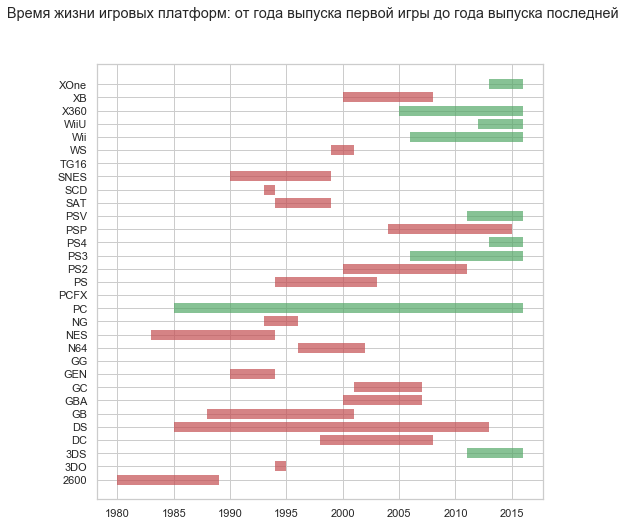

In [38]:
platform_lifetime_graph(games_df)

Выпуск игр в 2016 году продолжается для 9 платформ. Это:
- PC - персональные компьютеры
- XOne - XBox One, игровая приставка Microsoft, преемник Xbox 360. Конкуренты:  PlayStation 4 от Sony Computer Entertainment, Wii U от Nintendo. 
- X360 - Xbox 360, игровая приставка Microsoft, преемник Xbox. Конкуренты: PlayStation 3 от Sony Computer Entertainment и Wii от Nintendo
- WiiU - игровая приставка Nintendo. В отличие от Wii, ориентирована на более широкую игровую аудиторию.
- Wii - игровая приставка Nintendo, особенностью которой является "революционный контроллер консоли Wii"
- PSV - портативная консоль Sony Computer Entertainment, преемник PlayStation Portable
- PSP - PlayStation Portable, портативная игровая консоль Sony Computer Entertainment
- PS4 - PlayStation 4, игровая приставка Sony Computer Entertainment. Выпущена на смену PlayStation 3.
- PS3 - PlayStation 3, игровая приставка Sony Computer Entertainment. С самого момента выпуска приставкой поддерживается большинство игр для консолей предыдущего поколения, PlayStation и PlayStation 2.
- 3DS - портативная игровая система Nintendo, преемник Nintendo DS 

А с Nintendo DS явно какая-то проблема в данных, т.к. дата выхода - 2004 год, а в данных есть что-то за 1985. Проверю:

In [39]:
condition = (games_df.loc[:,'platform'] == 'DS') & (games_df.loc[:,'year_of_release'] < 2004)
games_df.loc[condition, :]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
15704,strongest tokyo university shogi ds,DS,1985,Action,0.0,0.0,0.02,0.0,NaN,NaN,unknown,0.0,0.02


[Явно какая-то ошибка](https://global.rakuten.com/en/store/mediaworldkaitoriworld/item/10200520001/). Удалю эту строку.

In [40]:
games_df.drop(index=15704, inplace=True)

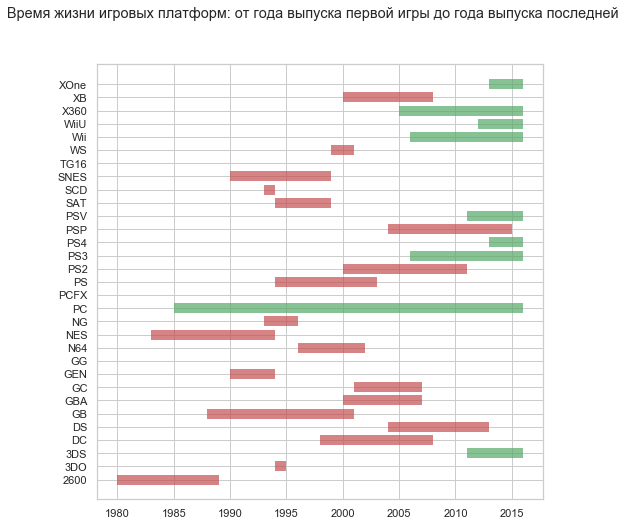

In [41]:
platform_lifetime_graph(games_df)

Теперь похоже на правду.

In [42]:
platform_life_start = games_df.groupby('platform')['year_of_release'].min()
platform_life_end = games_df.groupby('platform')['year_of_release'].max()
platform_lifetime = []
for index in platform_life_end[platform_life_end < 2016].index:
    platform_lifetime.append(platform_life_end[index]-platform_life_start[index])

In [43]:
lifetime_mean_std = np.std(platform_lifetime) / np.sqrt(len(platform_lifetime))
print('среднее время жизни игровой платформы, лет:', round(np.mean(platform_lifetime), 2))
print('стандартное отклонение среднего x 2, лет:', 2*round(lifetime_mean_std, 2) )
print('медианное время жизни игровой платформы, лет:', np.median(platform_lifetime))

среднее время жизни игровой платформы, лет: 6.14
стандартное отклонение среднего x 2, лет: 1.74
медианное время жизни игровой платформы, лет: 6.5


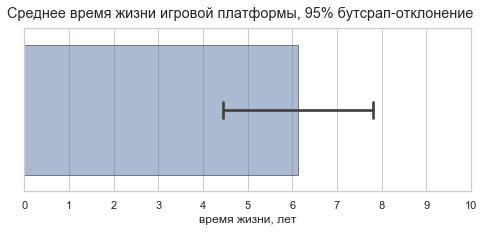

In [44]:
plt.figure(figsize=(8,3))
sns.barplot(platform_lifetime, ci=95, capsize=0.1, edgecolor=".1", alpha=0.5)
plt.suptitle('Среднее время жизни игровой платформы, 95% бутсрап-отклонение')
plt.xlabel('время жизни, лет')
plt.xticks(range(0,11,1))
plt.show()

Итак, среднее время жизни игровой платформы по оценке СКО составляет в 95% случаев$\ 6.14 \pm 1.74 $ лет. По оценке методом бутстрапа - примерно аналогично. Медианное - 6.5 лет (т.е. половина консолей живут 6.5 лет или менее)


Из платформ, для которых на момент 2016 года выпускаются игры, 5 появились после 2010 года (2011, 2012, 2013 гг.), 3 - после 2005 и им на смену уже выпущены новые платформы.

### 1.4.2 Анализ объёмов выпуска компьютерных игр по годам

In [45]:
games_df.loc[:, 'pc_flag'] = 'not PC'
games_df.loc[games_df.loc[:, 'platform'] == 'PC', 'pc_flag'] = 'PC'

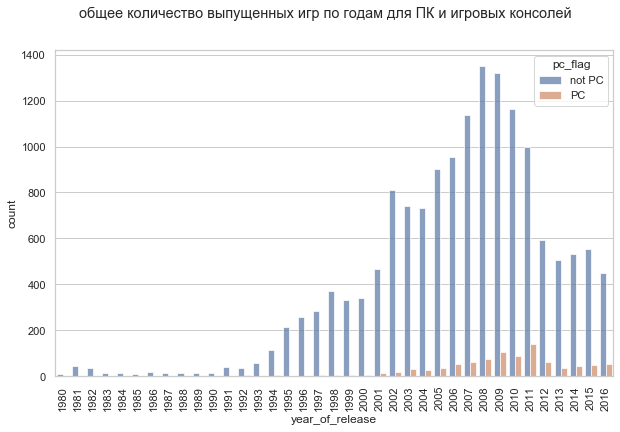

In [46]:
plt.figure(figsize=(10, 6))
plt.subplot()
sns.countplot(x='year_of_release', data = games_df, hue='pc_flag', alpha=0.7)
plt.suptitle('общее количество выпущенных игр по годам для ПК и игровых консолей')
plt.xticks(rotation=90)
plt.show()

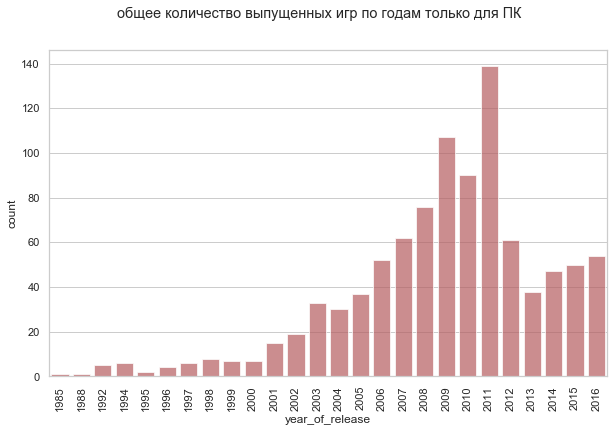

In [47]:
plt.figure(figsize=(10, 6))
plt.subplot()
plt.suptitle('общее количество выпущенных игр по годам только для ПК')
plt.xticks(rotation=90)
sns.countplot(x='year_of_release', data = games_df.loc[games_df.loc[:, 'platform'] == 'PC', :], color='r', alpha=0.7)
plt.show()

Развитие игровой индустрии активно началось с 1993 года, вместе с развитием компьютерной техники (появление микропроцессоров архитектуры x86 (Pentium) и проч.). Плавный рост наблюдается до конца 90х - начала 2000х годов. И для ПК и для игровых консолей после 2000г. число выпущенных игр растёт, в 2002 году - скачок числа выпущенных игр для консолей. Вероятно, это связано с развитием электроники (появление новых 32-х разрядных процессоров с новой архитектурой(Pentium 4)) и одновременным появлением культовых PlayStation2 и XBox, а также - Game Cube. Следующий резкий рост 2005-2008 гг. совпадает с бурным развитием игровых консолей, появлением XBox 360, Wii, PlayStation3. C 2009 по 2013 год резкий спад выпуска новых игр до уровня 2001 г. Возможно, связан с насыщением рынка, а также развитием смартфонов и игр для них. [В это время активно развиваются Android и iOS](https://xakep.ru/2014/09/25/ios-android-wphone-history/), многие консольные игры [становятся доступны для смартфонов](https://trashbox.ru/topics/109325/istoriya-razvitiya-mobilnyh-igr)  Затем снова незначительный рост, совпадающий с выходом новых платформ XBox One, PlayStation 4, PlayStation Viva, WiiU, 3DS. Бурного роста уже нет, так как серьёзную конкуренцию, вероятно, составляют игры для смартфонов. К тому же, удивить потребителя становится всё сложнее.

Несмотря на спад выпуска игр для приставок в 2016 году, в выпуске игр для ПК спада не наблюдается.

### 1.4.3 Самые успешные платформы: периоды наибольшей доходности

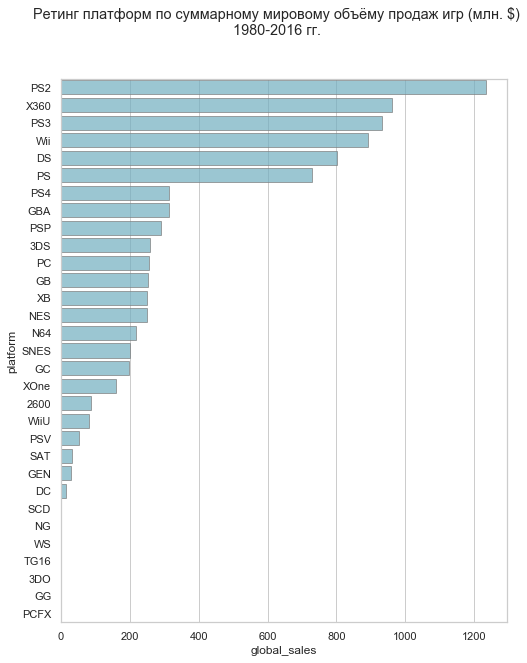

In [48]:
plt.figure(figsize=(8,10))
sorted_platform_list = games_df.groupby('platform')['global_sales'].sum().sort_values(ascending=False).index
sns.barplot(y='platform', x='global_sales', estimator=np.sum, color='c', edgecolor=".5", alpha=0.7, ci=None,
            order=sorted_platform_list, data=games_df)
plt.suptitle('Ретинг платформ по суммарному мировому объёму продаж игр (млн. $)\n1980-2016 гг.')
plt.show()

Топ-5 самых успешных платформ за период 1980-2016 годов: 'PS2', 'X360', 'PS3', 'Wii', 'DS'. Посмотрю на их примере, как меняются объёмы продаж новых игр в зависимости от того, сколько лет прошло с релиза консоли. 

In [49]:
top_platforms_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS']

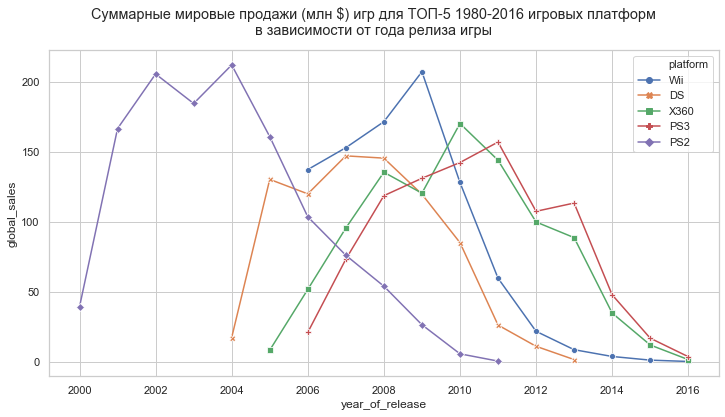

In [50]:
plt.figure(figsize=(12,6))
#plt.xticks(range(2012, 2017, 1))
sns.lineplot(x='year_of_release', y = 'global_sales', hue='platform', 
             estimator=np.sum, data=games_df.loc[games_df.loc[:, 'platform'].isin(top_platforms_list), :], 
             markers=True, dashes=False, style='platform', ci=None)
plt.suptitle('Суммарные мировые продажи (млн $) игр для ТОП-5 1980-2016 игровых платформ\nв зависимости от года релиза игры')
plt.show()

Для PS и DS основные объёмы продаж приходятся на игры, выпущенные черз 1-6 лет после релиза платформ. Затем спад. Максимум - у игр, выпущенных через 4-5 лет после релиза. У Wii игры года релиза были лучшими по объёмам продаж среди игр-"пионеров". Видно, что Wii был очень популярен в первые 4 года, затем продажи новых игр начали резко падать. PS3 и X360 показывают более плавный рост объёмов продаж и более плавный спад. Понятно, что говорить об объёмах продаж игр 2016 года на основании данных датасета нельзя, т.к. они могут быть неполными. Да и игры 2015 года продаются на момент выгрузки базы только год. Однако тенденция чётко видна у всех платформ: 

**объём продаж новых игр для консолей нарастает в первые 4-6 лет после выхода консоли, затем наблюдается спад. Так что в рекламе лучше ориентироваться на молодые консоли, которым не более 5 лет, и игры для них.**

Этот результат соотносится с полученным ранее временем жизни консоли.

Перед тем, как брать срез данных только актуального периода, очень интересно посмотреть "ТОП игр всех времён" по объёму продаж во всём мире.

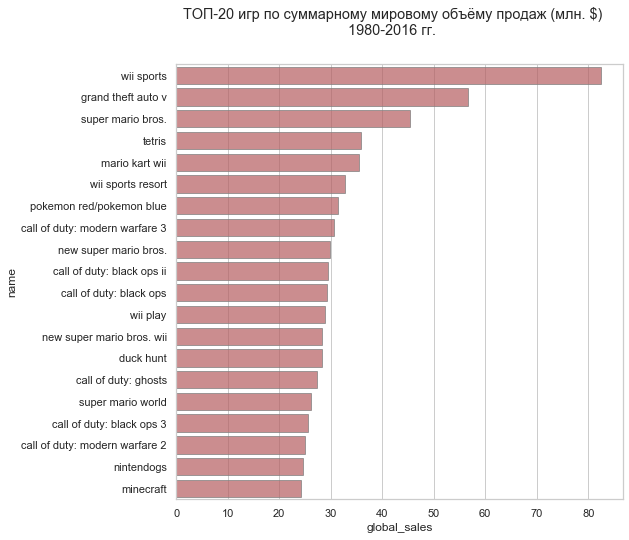

In [51]:
plt.figure(figsize=(8,8))
sorted_platform_list = games_df.groupby('name')['global_sales'].sum().sort_values(ascending=False).head(20).index
sns.barplot(y='name', x='global_sales', estimator=np.sum, color='r', edgecolor=".5", alpha=0.7, ci=None,
            order=sorted_platform_list, data=games_df)
plt.suptitle('ТОП-20 игр по суммарному мировому объёму продаж (млн. $)\n1980-2016 гг.')
plt.show()

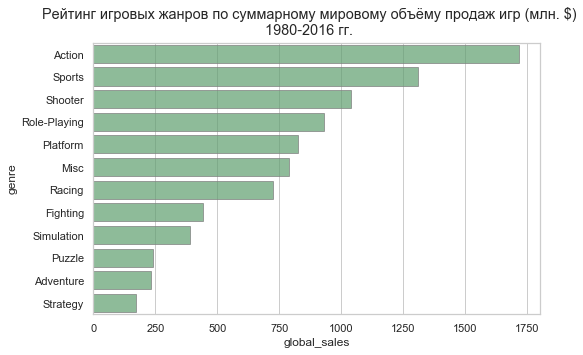

In [52]:
plt.figure(figsize=(8,5))
sorted_platform_list = games_df.groupby('genre')['global_sales'].sum().sort_values(ascending=False).head(20).index
sns.barplot(y='genre', x='global_sales', estimator=np.sum, color='g', edgecolor=".5", alpha=.7, ci=None,
            order=sorted_platform_list, data=games_df)
plt.suptitle('Рейтинг игровых жанров по суммарному мировому объёму продаж игр (млн. $)\n1980-2016 гг.')
plt.show()

Классика игр и классика жанров во весь рост. И Wii sports как показатель того, что с помощью инновационной идеи ([премия «Инновационная игра» в рубрике игра поколения по версии журнала Игромания](https://www.igromania.ru/article/24280/Igry_pokoleniya_Demons_Souls_Minecraft_Dwarf_Fortress.html)) и маркетинга ([за исключением Японии, она вложена прямо в коробку с Wii](https://ru.wikipedia.org/wiki/Wii_Sports)) можно обойти такую супер-классику, как марио и GTA. И это с учётом того, что как марио, так и GTA выпускаются для разных платформ, а Wii Sports - только для Wii. Вообще, Wii - показатель успеха философии motion-контроля Nintendo. За счёт инновационного контроллера и философии Nintendo выиграла 1 место в топе игр всех времён и вошла в пятерку лучших с не только с DS, но и с Wii.

На этом отступление в виде анализа всего периода закончу, а диаграммы оставлю для сравнения с данными за актуальный период.

<h2 style="color:DodgerBlue">Актуальный период времени для построения прогноза</h2>

В игровой индустрии существует понятие [current gen console](https://www.urbandictionary.com/define.php?term=current%20gen). Это новейшее поколение консолей, включая ПК, чья архитектура на их уровне или лучше. Период смены поколений по данным [wikipedia](https://en.wikipedia.org/wiki/Eighth_generation_of_video_game_consoles) составляет 6-7 лет.


*Current gen* домашних консолей - это 8 поколение. Включает консоли, представленные с 2012г. Nintendo, Microsoft, Sony. Для домашних видеоигровых консолей current gen стартовало 18 ноября 2012 года с релиза WiiU и продолжилось 15 ноября 2013 релизом PlayStation 4, 22 ноября 2013 - релизом XBox One. © [wikipedia](https://en.wikipedia.org/wiki/Eighth_generation_of_video_game_consoles) 


*Current gen* портативных консолей - 11 поколение. Стартовало в феврале 2011 года с релиза в Японии Nintendo 3DS, в декабре 2011 проболжилось релизом PlayStation Vita (PSV). © [wikipedia](https://en.wikipedia.org/wiki/Eighth_generation_of_video_game_consoles) 


- Время жизни консоли (время, когда на неё выпускаются игры) составляет в среднем 4.4-7.9 лет. 
- При этом в период до 2012 года наблюдался резкий спад выпуска игр, смена периодов. Чётко видно, что более-менее равномерная картина - с 2012 года. Брать для прогноза данные периода резкого спада и данные лет, в которые наблюдалась совсем иная картина выпуска игр, мне представляется некорректным. 
- Все актуальные на 2016 год консоли выпущены после 2011 года. Домашние консоли - в конце 2012 года. Те, что выпущены ранее - это предшествующие им модели тех же фирм производителей, которые, вероятно, будут вскоре сняты с производства.
- Объём продаж игр для новых консолей нарастает в первые 4-6 лет, затем наблюдается спад, часто - довольно резкий. Так что в рекламе лучше ориентироваться на молодые консоли, которым не более 4 лет, и игры для них.


**Исходя из этих соображений, выберу для прогноза данные 2013-2016 годов.**

Удалю pc_flag (использовался при анализе выпуска игр по годам) за ненадобностью.

In [53]:
games_df = games_df.loc[games_df.loc[:, 'year_of_release'] > 2012, :]

In [54]:
games_df.drop(columns=['pc_flag'], axis=1, inplace=True)

In [55]:
games_df.reset_index(drop=True, inplace=True)

<h1 style="color:SteelBlue"> Результаты разведочного анализа и подготовки данных</h1>

Выполнил проверку на дубликаты, обработал пропуски. Небольшую часть удалил (с отсутствующими годами выпуска и названиями игр и жанров, всего около 1.6%). Оценки пользователей 'tbd' заменил на nan. Пропуски в оценках пользователей и критиков оставил nan, т.к. заполнение медианой или средним может привести к смещению данных. Заполнение нехарактерными значениями также не использовал, чтобы не применять логические условия при построении диаграмм и расчёте корреляций. Пропуски в rating заменил на 'unknown', что соответствует логике. Обозначения ESRB заменил на соответствующие описания (everyone, unknown, 17+ и проч.).

Заменил типы данных: год привёл к целочисленному типу, оценки пользователей - к float. Остальные данные имеют правильные типы.


Провёл оценочный корреляционный анализ. Цель - выяснить, выделяется ли какой-то регион на фоне других и можно ли исключить часть признаков, заменив их общими. Выяснилось, что между объёмами продаж в Европе, Северной Америке и иных регионах, кроме Японии, наблюдаются сильные линейные связи. А вот продажи в Японии выделяются. Если есть планы развивать продажи в Стране Восходящего Солнца, нужно использовать особый подход.

Досчитал признаки: *not_jp_sales, global_sales.*


Выполнил разведочный анализ данных, выделил характерные периоды развития компьютерных игр. Исследовал время жини игровых платформ, получил список актуальных на 2016 год (тех, для которых выпускаются игры). Выдвинул гипотезы о причинах подъёмов и спадов на рынке компьютерных игр, отметив взаимосвязи с появлением новых игровых платформ и развитием технологий. 

На основе полученных результатов для прогноза на 2017 год взял наиболее актуальные данные: с 2013 по 2016 год. Это период, отражающий текущую (на 2016 г.) ситуацию на рынке компьютерных игр. Он начался в конце 2012 году, после завершения резкого спада в индустрии. К этому моменту появились все *current gen* платформы ,актуальные на момент 2016 года. Прочие платформы (кроме ПК) либо уже не выпускаются, либо заменяются новыми платформами.

Подготовил датасет:

In [56]:
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
0,grand theft auto v,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,17+,20.07,21.05
1,grand theft auto v,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,17+,16.21,16.27
2,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.27,14.63
3,pokemon x/pokemon y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,10.25,14.60
4,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,17+,12.24,12.62


In [57]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2233 entries, 0 to 2232
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             2233 non-null   object 
 1   platform         2233 non-null   object 
 2   year_of_release  2233 non-null   int32  
 3   genre            2233 non-null   object 
 4   na_sales         2233 non-null   float64
 5   eu_sales         2233 non-null   float64
 6   jp_sales         2233 non-null   float64
 7   other_sales      2233 non-null   float64
 8   critic_score     991 non-null    float64
 9   user_score       1192 non-null   float64
 10  rating           2233 non-null   object 
 11  not_jp_sales     2233 non-null   float64
 12  global_sales     2233 non-null   float64
dtypes: float64(8), int32(1), object(4)
memory usage: 218.2+ KB


- name — название игры
- platform — платформа
- year_of_release — год выпуска
- genre — жанр игры
- na_sales — продажи в Северной Америке (миллионы долларов)
- eu_sales — продажи в Европе (миллионы долларов)
- jp_sales — продажи в Японии (миллионы долларов)
- other_sales — продажи в других странах (миллионы долларов)
- critic_score — оценка критиков (максимум 100)
- user_score — оценка пользователей (максимум 10)
- rating — рейтинг от организации ESRB
- not_jp_sales  - продажи везде, кроме Японии (миллионы долларов)
- global_sales - общемировые продажи (миллионы долларов)

<h1 style="color:SteelBlue">2. Анализ мирового рынка игр 2013 - 2016 гг.</h1>

<h2 style="color:DodgerBlue">2.1 Объём выпуска и продаж игр разных жанров за 2013 - 2016 гг.</h2>

Посмотрю, как обстоят дела на мировом рынке в целом за выбранный период времени. Начну с анализа количества игр и объёмов их продаж в каждом из жанров.

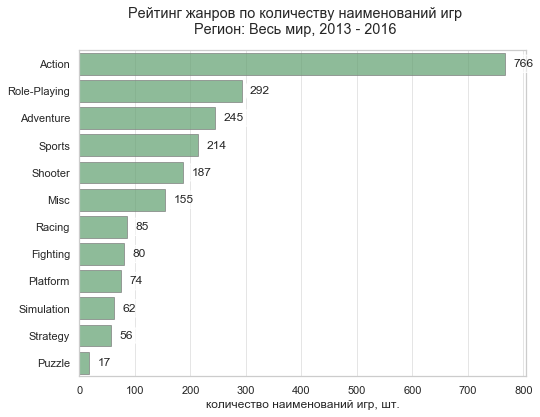

In [58]:
estimation_graph(games_df, groupby='genre', estimator='count')

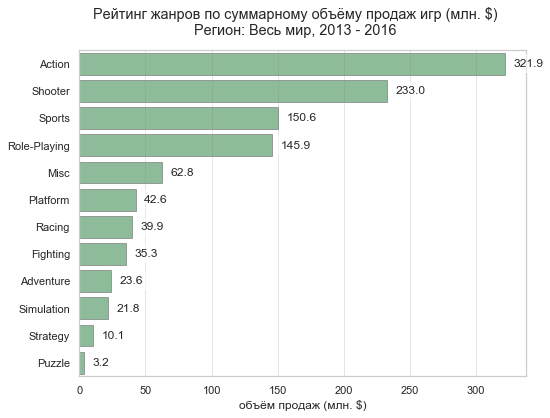

In [59]:
estimation_graph(games_df, groupby='genre')

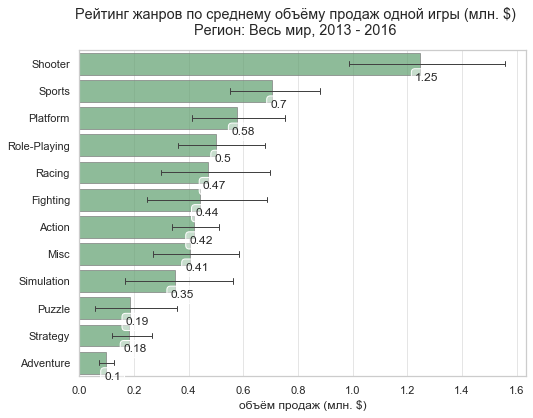

In [60]:
estimation_graph(games_df, groupby='genre', estimator='mean')

In [61]:
means_with_errors(games_df, groupby='genre', region='global_sales')

,genre,global_sales_mean,global_sales_mean_standard_error
0,Shooter,1.246,0.147
1,Sports,0.704,0.083
2,Platform,0.576,0.094
3,Role-Playing,0.500,0.079
4,Racing,0.469,0.105
5,Fighting,0.441,0.117
6,Action,0.420,0.045
7,Misc,0.405,0.081
8,Simulation,0.351,0.108
9,Puzzle,0.186,0.079


Больше всего игр в 2013-2016 годах было выпущено в жанре Action, он лидирует с большим отрывом. Далее следуют RPG, Adventure, Sport и Shooter. На 6 месте - игры смешанного типа. Меньше всего выпущено паззлов.

По объёмам продаж вновь лидирует жанр Action. За ним следуют Shooter, Sport и Role Playing. Прочие жанры проигрывают лидерам более чем в 2 раза. Паззлы вновь в аутсайдерах.

А вот по средним объёмам продаж одного наименования игры с большим отрывом лидируют Shooter. Причём, судя по 95% бутстрап-разбросу, это статистически значимое лидерство. Следом идёт Sport, который превышает Action, Misc, Simulation, Puzzle, Strategy, Adventure. А вот, Adventure, похоже, значимо хуже всех.

Можно показать статистически значимые различия в перестановочных тестах. Перестановочные тесты будут более корректны, чем классические, основанные на допущении о распределениях, т.к. распределения не являются нормальными:

In [62]:
genre_list = games_df['genre'].unique().tolist()
genre_dict = {}
for genre in genre_list:
    genre_dict[genre] = games_df.loc[games_df.loc[:, 'genre'] == genre, 'global_sales']

In [63]:
print('Проверка гипотез о нормальном характере распределения\nобъёмов продаж игр разных жанров:\n')
print("""
H0 - распределения являются нормальными
H1 - распределения отличаются от нормальных
Уровень значимости alpha приму равным 5% alpha= 0.05
     """)
for genre in genre_list:
    print(f'{genre}, pvalue={round(stats.normaltest(genre_dict[genre]).pvalue, 4)}')
print('\nОтвергаю нулевую гипотезу о нормальности распределений, p << alpha')

Проверка гипотез о нормальном характере распределения
объёмов продаж игр разных жанров:


H0 - распределения являются нормальными
H1 - распределения отличаются от нормальных
Уровень значимости alpha приму равным 5% alpha= 0.05
     
Action, pvalue=0.0
Shooter, pvalue=0.0
Role-Playing, pvalue=0.0
Misc, pvalue=0.0
Sports, pvalue=0.0
Fighting, pvalue=0.0
Racing, pvalue=0.0
Simulation, pvalue=0.0
Platform, pvalue=0.0
Strategy, pvalue=0.0
Adventure, pvalue=0.0
Puzzle, pvalue=0.0

Отвергаю нулевую гипотезу о нормальности распределений, p << alpha


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


Для того, чтобы проверить, что различия между жанрами действительно есть, использую дисперсионный анализ. Буду вычислять перестановочные f-статистики и сравнивать с оригинальной f-статистикой. На примере покажу, что результат аналогичен классическому дисперсионному анализу (хотя, строго говоря, при отличии распределений от нормальных он не должен использоваться; но известно, что f-ANOVA даёт верные результаты и при отличиях от "нормальности"). Для всех последующих статистических исследований приму:

- Уровень значимости alpha=0.05
- H0 - между средними выборок значимых различий нет (те различия, что есть, получены в результате случайности)
- H1 - средние выборок различаются между собой (различия, которые есть, могут быть получены случайно только в меньшей, чем alpha, доле случаев)

Сначала покажу, что среди всех жанров есть те, у которых средний объём продаж одной игры отличается от остальных. Это чётко видно на диаграмме, и всё же.

In [64]:
print('H0: Между средними объёмами продаж одной игры любых жанров различий нет:\n')
result = ANOVA_permutation_test(
    genre_dict['Shooter'],
    genre_dict['Sports'],
    genre_dict['Platform'], 
    genre_dict['Role-Playing'],
    genre_dict['Racing'],
    genre_dict['Fighting'],
    genre_dict['Action'],
    genre_dict['Misc'],
    genre_dict['Simulation'],
    genre_dict['Puzzle'],
    genre_dict['Strategy'],
    genre_dict['Adventure']
                       )
print(result)
if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha=0.05, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha=0.05, pvalue={result.pvalue}')

H0: Между средними объёмами продаж одной игры любых жанров различий нет:

ANOVA_PermutationResult(f_statistic=10.501332446139974, iterations=10000, pvalue=0.0)

Отвергаем нулевую гипотезу: alpha=0.05, pvalue=0.0


Уберу Shooter из сравнения:

In [65]:
print('H0: Между средними объёмами продаж одной игры любых жанров, кроме Shooter, различий нет:\n')
result = ANOVA_permutation_test(
    genre_dict['Sports'],
    genre_dict['Platform'], 
    genre_dict['Role-Playing'],
    genre_dict['Racing'],
    genre_dict['Fighting'],
    genre_dict['Action'],
    genre_dict['Misc'],
    genre_dict['Simulation'],
    genre_dict['Puzzle'],
    genre_dict['Strategy'],
    genre_dict['Adventure']
                       )
print(result)
if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha=0.05, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha=0.05, pvalue={result.pvalue}')

H0: Между средними объёмами продаж одной игры любых жанров, кроме Shooter, различий нет:

ANOVA_PermutationResult(f_statistic=4.203029109220161, iterations=10000, pvalue=0.0016)

Отвергаем нулевую гипотезу: alpha=0.05, pvalue=0.0016


Теперь уберу Shooter и Adventure:

In [66]:
result = ANOVA_permutation_test(
    genre_dict['Sports'],
    genre_dict['Platform'], 
    genre_dict['Role-Playing'],
    genre_dict['Racing'],
    genre_dict['Fighting'],
    genre_dict['Action'],
    genre_dict['Misc'],
    genre_dict['Simulation'],
    genre_dict['Puzzle'],
    genre_dict['Strategy']
    )

classic_result = stats.f_oneway(
    genre_dict['Sports'],
    genre_dict['Platform'], 
    genre_dict['Role-Playing'],
    genre_dict['Racing'],
    genre_dict['Fighting'],
    genre_dict['Action'],
    genre_dict['Misc'],
    genre_dict['Simulation'],
    genre_dict['Puzzle'],
    genre_dict['Strategy']
    )
print('H0: Между средними объёмами продаж одной игры любых жанров, кроме Shooter и Adventure, различий нет:')
print(result)
print('\nПроверка перестановочного теста классической one-way f-ANOVA:')
print(classic_result)

if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha=0.05, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha=0.05, pvalue={result.pvalue}')

H0: Между средними объёмами продаж одной игры любых жанров, кроме Shooter и Adventure, различий нет:
ANOVA_PermutationResult(f_statistic=1.7947793541412722, iterations=10000, pvalue=0.0824)

Проверка перестановочного теста классической one-way f-ANOVA:
F_onewayResult(statistic=1.794779354141273, pvalue=0.06457940147363674)

Нет оснований отвергать нулевую гипотезу: alpha=0.05, pvalue=0.0824


И вот здесь видно, что различия между остальными жанрами уже не столь статистически значимы. Наверняка, с риском совершить ошибку первого рода более 5%, можно выделить жанр Sport. Но, если говорить строго, оснований отвергать нулевую гипотезу нет. Если убрать из жанров ещё и спорт, то увидим, что между средними объёмами продаж игр остальных жанров различий нет (точнее, они более чем в половине случаев могут быть получены случайно):

In [67]:
result = ANOVA_permutation_test(
    genre_dict['Platform'], 
    genre_dict['Role-Playing'],
    genre_dict['Racing'],
    genre_dict['Fighting'],
    genre_dict['Action'],
    genre_dict['Misc'],
    genre_dict['Simulation'],
    genre_dict['Puzzle'],
    genre_dict['Strategy']
    )

classic_result = stats.f_oneway(
    genre_dict['Platform'], 
    genre_dict['Role-Playing'],
    genre_dict['Racing'],
    genre_dict['Fighting'],
    genre_dict['Action'],
    genre_dict['Misc'],
    genre_dict['Simulation'],
    genre_dict['Puzzle'],
    genre_dict['Strategy']
    )
print('H0: Между средними объёмами продаж одной игры любых жанров, кроме Shooter, Adventure, Sport различий нет:')
print(result)
print('\nПроверка перестановочного теста классической one-way f-ANOVA:')
print(classic_result)

if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha={alpha}, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha={alpha}, pvalue={result.pvalue}')

H0: Между средними объёмами продаж одной игры любых жанров, кроме Shooter, Adventure, Sport различий нет:
ANOVA_PermutationResult(f_statistic=0.7506335911029822, iterations=10000, pvalue=0.5948)

Проверка перестановочного теста классической one-way f-ANOVA:
F_onewayResult(statistic=0.7506335911029832, pvalue=0.6466654318371703)

Нет оснований отвергать нулевую гипотезу: alpha=0.05, pvalue=0.5948


Можно показать, что в рекламной кампании жанру Action стоит предпочесть жанр Sport (проверю результат перестановочного теста классическим t-тестом (для оценки; понятно, что распределения не являются нормальными и применять его, строго говоря, некорректно)). Множественных сравнений проводить не буду, поэтому поправка не понадобится.

In [68]:
result = AB_permutation_test(
    genre_dict['Sports'],
    genre_dict['Action']
                       )
classic_result = stats.ttest_ind(genre_dict['Sports'], genre_dict['Action'])

print('H0: Между средними объёмами продаж одной игры жанров Sports и Action различий нет')
print(result)
print('\nПроверка перестановочного классическим t-тестом:')
print(classic_result)

if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')

H0: Между средними объёмами продаж одной игры жанров Sports и Action различий нет
AB_PermutationResult(means_difference=0.2837761401625143, iterations=10000, pvalue=0.0036)

Проверка перестановочного классическим t-тестом:
Ttest_indResult(statistic=2.944507188834804, pvalue=0.0033112413584144196)

Отвергаем нулевую гипотезу: alpha=0.05, pvalue=0.0036


Средний объём продаж игры жанра Sports выше, чем Action.

<h2 style="color:DodgerBlue">Объём мирового выпуска и продаж игр разных жанров за 2013 - 2016 гг. Результаты анализа</h2>

**По объёму выпуска игр однозначно лидирует жанр Action (766 наименований игр)**. За ним следуют RPG, Adventure, Sports и Shooter (292, 245, 214, 187 игр соответственно). Меньше всего выпущено паззлов (17 игр).

Если смотреть на мир в целом, то в 2013-2016 годах между продажами игр разных жанров есть отличия, в том числе - статистически значимые.

**По суммарным объёмам продаж лидирует жанр Action (321.9 млн. долл.).** За ним следуют **Shooter, Sport и Role Playing** (233.0, 150.6, 145.9 млн. долл.). Прочие жанры проигрывают лидерам более чем в 2 раза (Misc на 5 месте с 62.8 млн. долл.). Паззлы вновь в аутсайдерах (3.2 млн. долл.).

А вот по **средним объёмам продаж одной игры безоговорочно и статистически значимо лидируют Shooter с 1.25 +/- 0.3 млн. долл.** (здесь и далее допуск указан на основании расчёта стандартной ошибки среднего, границы допуска - удвоенная ошибка среднего, соответствует примерно 95% случаев при нормальном распределении среднего). Значимо отстаёт от прочих Adventure с 0.096 +/- 0.028 млн. долл. Среди остальных жанров выделяется Sports с 0.704 +/- 0.166 млн. долл. Например, с высокой степенью уверенности (alpha=0.0042, pvalue=0.0038) средние продажи игры жанра Sports превышают Action.

Эти результаты указывают, что, в общем случае, в рекламной кампании **стоит предпочесть Shooter, Action и Sport**. Action - как жанр, в котором выпускается больше всего игр и самый большой объём продаж. Средние продажи игр Action находятся на твёрдых промежуточных позициях с 0.42 +/- 0.09 млн. долл. Shooter - как жанр, который наиболее успешен в средних объёмах продаж на игру. По суммарным объёмам он второй в мире после Action, но одна игра Shooter в среднем принесла в 3 раза больше, чем Action. Sport - второй по средним объёмам продаж одной игры и в этом он значимо превосходит Action. Также по объёмам продаж перспективен жанр **RPG**.

**Не стоит ориентироваться на Puzzle и Adventure**. Хотя, стоит отметить, что Puzzle, наверняка, дешевле в себестоимости и закупке и может быть интересен определённой аудитории.

<h2 style="color:DodgerBlue">2.2 Выбор перспективных платформ. Анализ продаж игр для них в 2013 - 2016 гг.</h2>

Понятно, что не имеет смысла ориентироваться в рекламных кампаниях на платформы, покидающие рынок. При выборе актуального периода для анализа я уже отмечал, что в рекламе лучше ориентироваться на молодые консоли, которым не более 4 лет, и игры для них. Т.е. это всё - [*current gen* консоли](https://en.wikipedia.org/wiki/Eighth_generation_of_video_game_consoles).

*Current gen* домашних консолей - это **WiiU, PlayStation 4, XBox One**.

*Current gen* портативных консолей - **Nintendo 3DS, PlayStation Vita (PSV)**.

Также в анализе должны присутствовать PC, так как *current gen* включают ПК, чья архитектура на их уровне или лучше.

Можно проанализировать графики суммарных мировых продаж игр для игровых платформ 2013-2016 годов в зависимости от года релиза игры, чтобы подтвердить эти рассуждения:

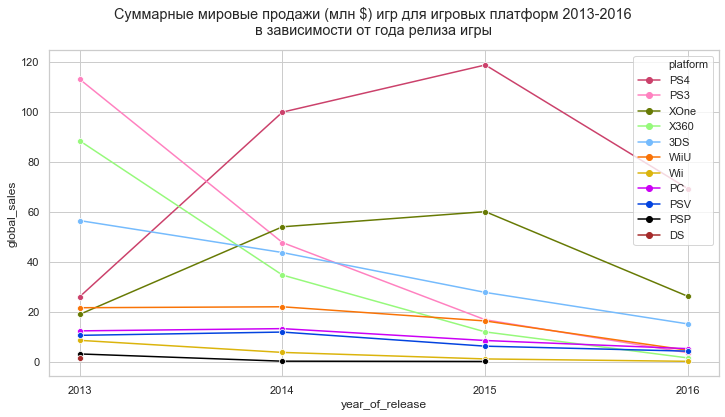

In [69]:
plt.figure(figsize=(12,6))
plt.xticks(range(2012, 2017, 1))
sns.lineplot(x='year_of_release', y = 'global_sales', hue='platform', hue_order=platform_color_dict.keys(),
             estimator=np.sum, palette=platform_color_dict, data=games_df, 
             markers=['o' for key in platform_color_dict.keys()], dashes=False, style='platform', ci=None)
plt.suptitle('Суммарные мировые продажи (млн $) игр для игровых платформ 2013-2016\nв зависимости от года релиза игры')
plt.show()


Графики, действительно, подтверждают выбор *current gen*. Видно, что продажи новых игр для XBox 360 и PS3 устойчиво снижались с выходом PlayStation 4 и XBox One. В задаче оговорено, что данные за 2016 год могут быть неполными, поэтому спад 2015-2016 продаж игр может быть вызван отсутствием данных. К тому же, игры 2016 г на момент выгрузки базы только вышли и многие продажи ещё не произошли.

В рамках периода, который рассматривается, действительно произошли изменения. Сменились поколения самых популярных платформ. PS3 и XBox 360 уже почти ушли с рынка, уступив PS4 и XBox One. Эти две платформы на 2016 год по суммарным объёмам продаж - наиболее перспективные из всех. За ними следует 3DS. WiiU, PC и PSV занимют примерно одинаковое положение.

Понятно, почему PSP и Nintendo DS в аутсайдерах: игры для них уже не выпускаются. Рассматриваемый период - их закат.

Далее буду анализировать платформы: 
- PlayStation 4
- XBox One
- WiiU
- PC
- Nintendo 3DS
- PlayStation Vita.

Посмотрим, как вообще распределены продажи по платформам за 2013-2016 гг.

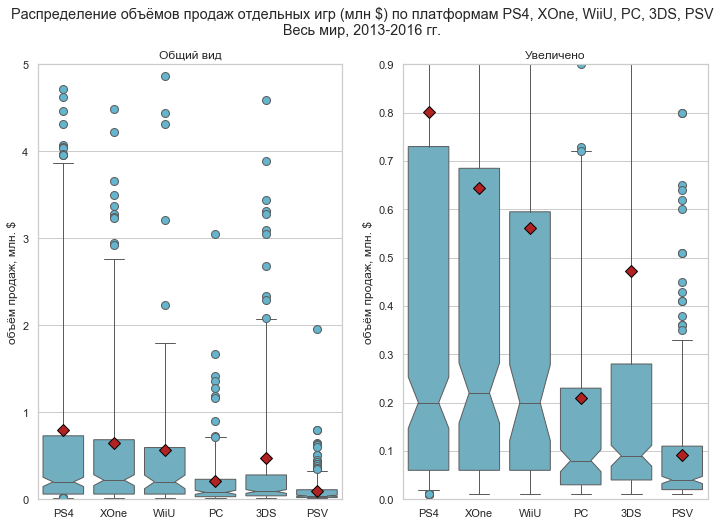

In [70]:
games_gen8_df = games_df.loc[games_df.loc[:, 'platform'].isin(gen8_platform_list), :]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
axs[0].set_ylim(0,5)
axs[1].set_ylim(0,0.9)
axs[0].set_title('Общий вид')
axs[1].set_title('Увеличено')
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markersize=8, markerfacecolor='firebrick')

flierprops = dict(marker='o', markerfacecolor='c', markersize=8,
                  linestyle='none')

plt.suptitle(f'Распределение объёмов продаж отдельных игр (млн $) по платформам {", ".join(gen8_platform_list)}\nВесь мир, 2013-2016 гг.')

for ax in axs:
    sns.boxplot(ax=ax, x='platform', y='global_sales', data=games_gen8_df, 
                color='c',
                order = gen8_platform_list, 
                showmeans=True, notch=True, meanprops=meanpointprops,
                flierprops=flierprops, linewidth=1, whis=(5,95))
    ax.set_ylabel('объём продаж, млн. $')
    ax.set_xlabel('')

По средним и медианным значениям лидируют PS4, XOne, WiiU. Медианы объёмов продаж игр для них за 3 года примерно равны и составляют около 200 тыс. долл., а средние различаются. Видно, что довольно много игр находятся за пределами 5-95% интервала со стороны больших значений. Т.е. есть игры, которые продаются лучше, особенно много таких для PS4, XOne и 3DS. Но WiiU по игре-хиту всех обошёл (и это, конечно, mario cart, см. далее). ПК проигрывает флагманам по объёмам продаж игр. Среди портативных консолей гораздо больше объёмы продаж у игр для 3DS, чем для PSV. Есть и такие игры для 3DS, которые принесли более 4 млн $.

Интересно, какие игры так тянут вверх объёмы продаж флагманских консолей. Посмотрим ТОП-5 игр для этих платформ за 2013-2016 гг. по суммарным мировым продажам:

In [73]:
print('ТОП-5 игр для PS4 по мировым продажам 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == 'PS4', :].sort_values(by='global_sales', ascending=False).head(5)

ТОП-5 игр для PS4 по мировым продажам 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
2,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.27,14.63
4,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,17+,12.24,12.62
9,fifa 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,everyone,8.52,8.58
10,star wars battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.76,7.98
11,call of duty: advanced warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,17+,7.52,7.66


In [74]:
print('ТОП-5 игр для XOne по мировым продажам 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == 'XOne', :].sort_values(by='global_sales', ascending=False).head(5)

ТОП-5 игр для XOne по мировым продажам 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
14,call of duty: black ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.38,7.39
22,grand theft auto v,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,17+,5.47,5.47
24,call of duty: advanced warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,17+,5.25,5.26
31,halo 5: guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,13+,4.46,4.49
39,fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,17+,4.21,4.22


In [75]:
print('ТОП-5 игр для WiiU по мировым продажам 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == 'WiiU', :].sort_values(by='global_sales', ascending=False).head(5)

ТОП-5 игр для WiiU по мировым продажам 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
17,mario kart 8,WiiU,2014,Racing,3.15,2.15,1.28,0.51,88.0,9.1,everyone,5.81,7.09
27,super smash bros. for wii u and 3ds,WiiU,2014,Fighting,2.60,1.08,0.81,0.38,NaN,NaN,unknown,4.06,4.87
33,splatoon,WiiU,2015,Shooter,1.54,1.18,1.46,0.26,81.0,8.5,10+,2.98,4.44
35,super mario 3d world,WiiU,2013,Platform,2.11,1.16,0.73,0.32,93.0,9.0,everyone,3.59,4.32
70,super mario maker,WiiU,2015,Platform,1.18,0.89,0.94,0.20,88.0,8.7,everyone,2.27,3.21


In [76]:
print('ТОП-5 игр для 3DS по мировым продажам 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == '3DS', :].sort_values(by='global_sales', ascending=False).head(5)

ТОП-5 игр для 3DS по мировым продажам 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
3,pokemon x/pokemon y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,10.25,14.60
5,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,8.58,11.68
13,super smash bros. for wii u and 3ds,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,unknown,5.12,7.55
16,pokemon sun/moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,unknown,4.88,7.14
26,tomodachi life,3DS,2013,Simulation,0.97,2.11,1.90,0.24,NaN,NaN,unknown,3.32,5.22


ТОП-5 игр PS4 и XBox - это классика жанров shooters, action, sports, RPG: Call of Duty, GTA, FIFA, fallout. 

ТОП-5 WiiU - Марио, покемоны и splatoon.

ТОП-5 3DS представлен покемонами и симулятором жизни tomodachi life.

О чём говорит рейтинг? Есть игры "must have". Mario, Pokemon, Call of Duty, GTA, fallout, FIFA. Они очень здорово тянут платформы, на которых популярны. Например, WiiU, жанр Platform, просто "едет" на Марио. Забегая вперёд, смотрю на Японию. Не любят японцы шутеров. В отличии от все остальных.

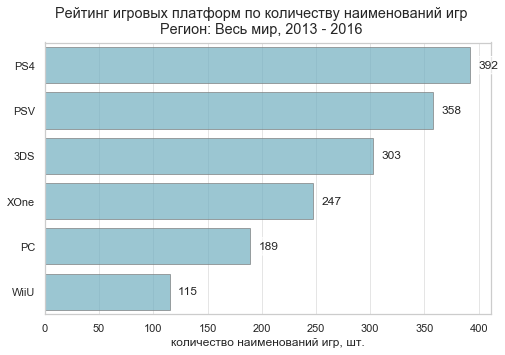

In [77]:
estimation_graph(games_gen8_df, groupby='platform', estimator='count', figsize=(8,5))

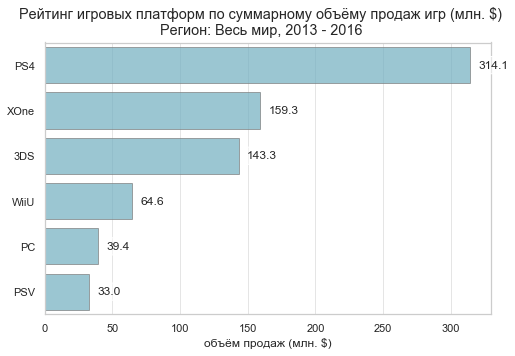

In [78]:
estimation_graph(games_gen8_df, groupby='platform', estimator='sum', figsize=(8,5))

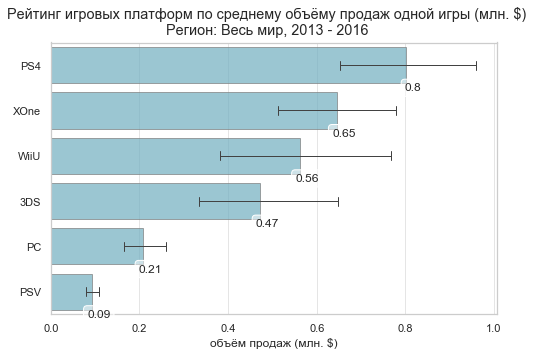

In [79]:
estimation_graph(games_gen8_df, groupby='platform', estimator='mean', figsize=(8,5))

In [80]:
means_with_errors(games_gen8_df, groupby='platform', region='global_sales')

,platform,global_sales_mean,global_sales_mean_standard_error
0,PS4,0.801,0.081
1,XOne,0.645,0.066
2,WiiU,0.562,0.097
3,3DS,0.473,0.079
4,PC,0.209,0.026
5,PSV,0.092,0.008


Лидер по количеству игр, суммарному и среднему объёму продаж - **PS4.** Интересно, что по количеству выпущенных игр на 2 месте PSV, а вот по объёмам продаж она на последжнем месте. Возможно, популярна только в каком-то одном регионе. По объёмам продаж за PS4 уверенно следуют XBox One и 3DS, более чем в 2 раза опережая WiiU.


Среднее значение выше всех у PS4, за ней следуют XOne, WiiU, 3DS. однако бутстрап разброс показывает, что значимых отличий нет. Зато видно, что PSV проигрывает всем, а PC - всем, кроме PSV. Преимущество 3DS перед PSV очевидно и по медианному уровню продаж, и по среднему, и по суммарному.

Посмотрю, какие жанры для каких платформ продавались лучше всего в 2013-2016 гг.

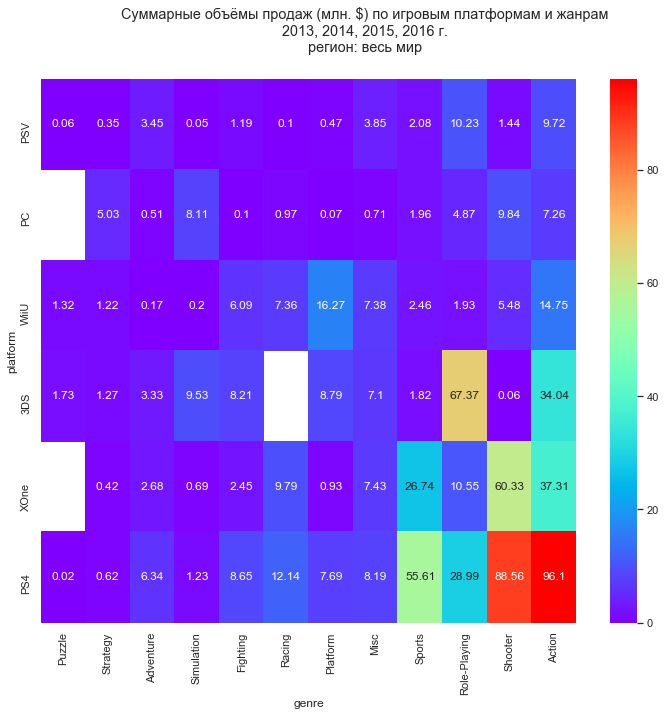

In [81]:
genres_platforms_heatmap(games_gen8_df)

<h2 style="color:DodgerBlue">Результаты выбора перспективных платформ и анализа мировых продаж игр для них</h2>

Все перспективные консоли - это [*current gen* консоли](https://en.wikipedia.org/wiki/Eighth_generation_of_video_game_consoles).

- *Current gen* домашних консолей - это **WiiU, PlayStation 4, XBox One**.
- *Current gen* портативных консолей - **Nintendo 3DS, PlayStation Vita (PSV)**.
- Также в анализе должны присутствовать **PC**, так как *current gen* включают ПК, чья архитектура на их уровне или лучше.

**Рейтинг по суммарному объёму продаж среди консолей:**
- **PS4** 314.1 млн. долл.
- **XBox One и 3DS** 159.3 и 143.3 млн. долл.
- **WiiU** с более чем двукратным отставанием от 3DS 64.6 млн. долл.
- **PC и PSV** 39.4 и 33 млн. долл

Средний объём продаж одной игры выше всех у PS4, за ней следуют XOne, WiiU, 3DS. Однако бутстрап разброс показывает, что значимых отличий нет. Тем не менее, можно уверенно говорить, что по средим объёмам продаж **PC проигрывает всем домашним консолям, а также - 3DS. PSV, в свою очередь, проигрывает PC.** PSV на 2 месте по количеству игр, но по объёму продаж эта платформа - аутсайдер.


**В сочетании жанр-платформа по суммарным мировым продажам однозначно выделяются:**
- **Action и Shooter для PS4**
- **RPG для 3DS**
- **Shooter для XBox One** 
- **Sports для PS4**


**ТОП-5 игр PS4 и XBox** - классика жанров shooters, action, sports, RPG: Call of Duty, GTA, FIFA, fallout.


**ТОП-5 WiiU** - racing, fighting, shooter, platform. Но всё это - Марио, покемоны и splatoon.


**ТОП-5 3DS** представлен покемонами и симулятором жизни tomodachi life. RPG, Fighting, Simulation.


Есть игры "must have". Mario, Pokemon, Call of Duty, GTA, fallout, FIFA. Они очень здорово тянут платформы, на которых популярны. Вообще, становится очевидно, что "имя" игры едва ли не важнее жанра и платформы. Также видно, что жанр и платформу нужно рассматривать в связке. И Японию нужно рассматривать отдельно. А возможно, и не только Японию.

<h2 style="color:DodgerBlue">2.3 Сравнение рынков Японии, Северной Америки и Европы</h2>

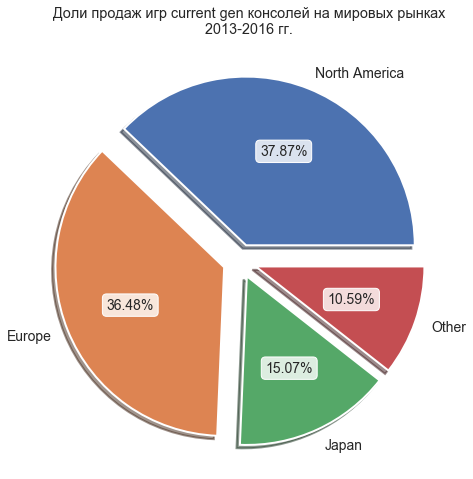

In [82]:
na_sales = games_gen8_df['na_sales'].sum()
eu_sales = games_gen8_df['eu_sales'].sum()
jp_sales = games_gen8_df['jp_sales'].sum()
other_sales = games_gen8_df['other_sales'].sum()
sales = [na_sales, eu_sales, jp_sales, other_sales]
labels = ['North America', 'Europe', 'Japan', 'Other']

wedgeprops = {"linewidth": 2, "edgecolor": "white"}
textprops = {"fontsize": 14, 'bbox': dict(boxstyle="round", fc=(1, 1, 1, 0.8))}

plt.figure(figsize=(7,7))
plt.suptitle('Доли продаж игр current gen консолей на мировых рынках\n2013-2016 гг.')

plt.pie(sales, labels=labels,
        shadow=True,
        autopct = "%0.2f%%",
        explode = [0.1, 0.1, 0.1, 0.1],
        wedgeprops = wedgeprops,
        textprops = textprops)

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()
#total_sales

In [84]:
std_eu_mean = games_gen8_df.loc[:, 'eu_sales'].std() / np.sqrt(len(games_gen8_df.loc[:, 'eu_sales']))
std_na_mean = games_gen8_df.loc[:, 'na_sales'].std() / np.sqrt(len(games_gen8_df.loc[:, 'na_sales']))
std_jp_mean = games_gen8_df.loc[:, 'jp_sales'].std() / np.sqrt(len(games_gen8_df.loc[:, 'jp_sales']))
std_othr_mean = games_gen8_df.loc[:, 'other_sales'].std() / np.sqrt(len(games_gen8_df.loc[:, 'other_sales']))

print(f"""Cредние объёмы продаж игр 2013-2016, все платформы: 

в Европе: 
{round(games_gen8_df.loc[:, 'eu_sales'].mean(), 2)}  +/- {round(2*std_eu_mean, 3)} млн. $

в Северной Америке: 
{round(games_gen8_df.loc[:, 'na_sales'].mean(), 2)} +/- {round(2*std_na_mean, 3)} млн. $

в Японии: 
{round(games_gen8_df.loc[:, 'jp_sales'].mean(), 2)} +/- {round(2*std_jp_mean, 3)} млн. $

в других регионах: 
{round(games_gen8_df.loc[:, 'other_sales'].mean(), 2)} +/- {round(2*std_othr_mean, 3)} млн. $
""")


print(f"""\nСуммарные объёмы продаж игр 2013-2016, все платформы: 

в Европе: 
{round(games_gen8_df.loc[:, 'eu_sales'].sum(), 2)} млн. $

в Северной Америке: 
{round(games_gen8_df.loc[:, 'na_sales'].sum(), 2)} млн. $

в Японии: 
{round(games_gen8_df.loc[:, 'jp_sales'].sum(), 2)} млн. $

в остальных регионах: 
{round(games_gen8_df.loc[:, 'other_sales'].sum(), 2)} млн. $
""")

Cредние объёмы продаж игр 2013-2016, все платформы: 

в Европе: 
0.17  +/- 0.024 млн. $

в Северной Америке: 
0.18 +/- 0.024 млн. $

в Японии: 
0.07 +/- 0.013 млн. $

в других регионах: 
0.05 +/- 0.007 млн. $


Суммарные объёмы продаж игр 2013-2016, все платформы: 

в Европе: 
274.95 млн. $

в Северной Америке: 
285.42 млн. $

в Японии: 
113.58 млн. $

в остальных регионах: 
79.81 млн. $



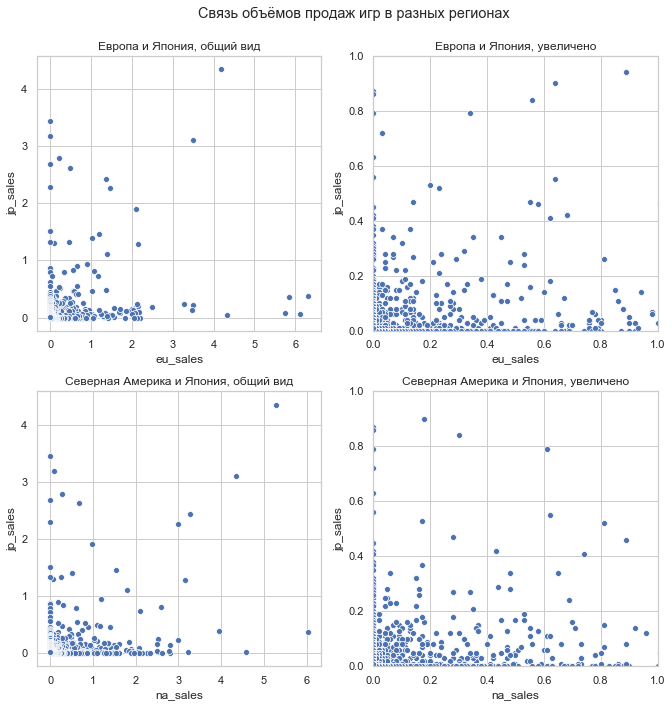

In [87]:
plt.figure(figsize=(10,10))
plt.suptitle("Связь объёмов продаж игр в разных регионах")

plt.subplot(221)
sns.scatterplot(x='eu_sales', y='jp_sales',  data=games_gen8_df)
plt.title("Европа и Япония, общий вид")

plt.subplot(222)
sns.scatterplot(x='eu_sales', y='jp_sales', data=games_gen8_df)
plt.title("Европа и Япония, увеличено")
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.subplot(223)
sns.scatterplot(x='na_sales', y='jp_sales', data=games_gen8_df)
plt.title("Северная Америка и Япония, общий вид")

plt.subplot(224)
sns.scatterplot(x='na_sales', y='jp_sales', data=games_gen8_df)
plt.title("Северная Америка и Япония, увеличено")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

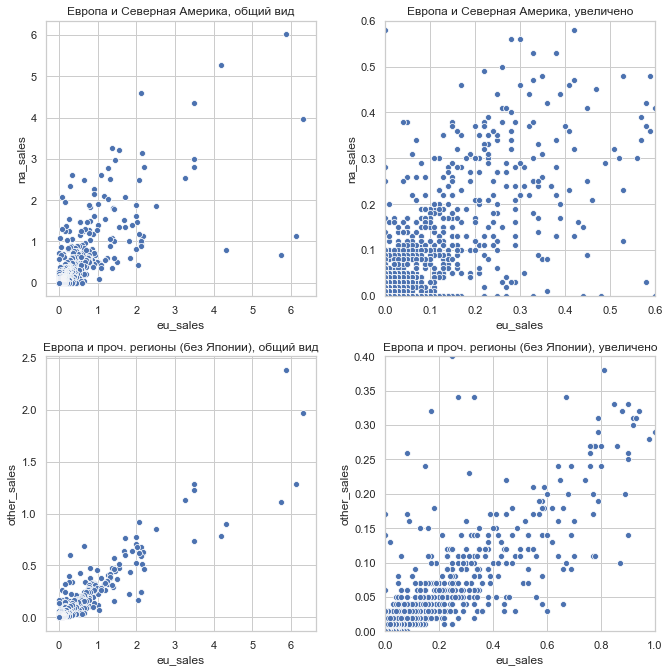

In [88]:
plt.figure(figsize=(10,10))
plt.subplot(221)
sns.scatterplot(x='eu_sales', y='na_sales',  data=games_gen8_df)
plt.title("Европа и Северная Америка, общий вид")

plt.subplot(222)
sns.scatterplot(x='eu_sales', y='na_sales', data=games_gen8_df)
plt.title("Европа и Северная Америка, увеличено")
plt.xlim(0, 0.6)
plt.ylim(0, 0.6)

plt.subplot(223)
sns.scatterplot(x='eu_sales', y='other_sales', data=games_gen8_df)
plt.title("Европа и проч. регионы (без Японии), общий вид")

plt.subplot(224)
sns.scatterplot(x='eu_sales', y='other_sales', data=games_gen8_df)
plt.title("Европа и проч. регионы (без Японии), увеличено")
plt.xlim(0, 1)
plt.ylim(0, 0.4)
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

Рынок компьютерных игр Японии очень обширный. Одна страна сопоставима по объёмам продаж с целыми регионами.

Из диаграмм видно, что рынок Японии сильно отличается от рынков остального мира. Поэтому рассматривать общую картину не стоит: результаты будут недостоверными. Рынок Европы, несмотря на коэффициенты корреляций 0,8, не очень похож на рынок Северной Америки. На диаграмме рассеяния - вполне рассеянное облако. Хотя, конечно, видна схожесть тенденций.

Таким образом, нужно проанализировать Северную Америку, Европу и Японию отдельно.

<h1 style="color:SteelBlue">Результаты анализа мирового рынка игр 2013 - 2016 гг.</h1>

За предшествующие 2017 году 10 лет в игровой индустрии наметился спад, который продолжается и в 2016 году. Однако, немотря на это, объёмы продаж по ряду консолей и жанров держатся на хорошем уровне. Судя по всему, за счёт роста популярности shooter, в особенности - Call of Duty, консоли PS4 и XBox растут по объёмам продаж (как и шутеры). Классика, такая, как Марио и Покемоны, остаётся классикой и удерживает позиции.

**Среди портативных консолей** выделяется **Nintendo 3DS** с жанрами **Role-Playing и Action**. При ближайшем рассмотрении значительную часть объёмов продаж обеспечивают **игры вселенной покемонов.**


**Среди стационарных консолей** по мировым объёмам продаж лидируют **Sony PlayStation 4 и XBox One** с жанрами **Action, Shooter, Sports, Role-Playing.** В этих жанрах для указанных консолей выделяются **Call of Duty, GTA, FIFA, Fallout.**

Жанры с самыми большими объёмами продаж для **WiiU** - **Platform и Action**. Это во многом заслуга игр классических серий: **Марио и Покемонов**

Абсолютный лидер по играм в жанре **Strategy - PC**

Объёмы мировых продаж во всех регионах, кроме Японии, сильно линейно взаимосвязаны.

По объёмам продаж между регионами есть различия. Европа и Северная Америка почти не различаются, но превосходят остальные регионы. При этом объём продаж на рынке компьютерных игр Японии довольно значительный: одна страна сопоставима с целыми регионами.

Несмотря на корреляции между продажами в Европе и Северной Америке, по диаграммам рассеяния видно, что рынки регионов различаются. Рынок Японии самобытен и разительно отличается от всех прочих. Страна восходящего Солнца требует особого подхода к рекламе.

<h1 style="color:SteelBlue">3. Рынки компьютерных игр Японии, Северной Америки и Европы</h1>

<h2 style="color:DodgerBlue">3.1 Популярные консоли и жанры. Страна восходящего Солнца.</h2>

Уже очевидно, что тенденции в Японии и в остальном мире отличаются. И для продаж в этом регионе нужен особый подход. Посмотрим, какие консоли и жанры здесь популярны.

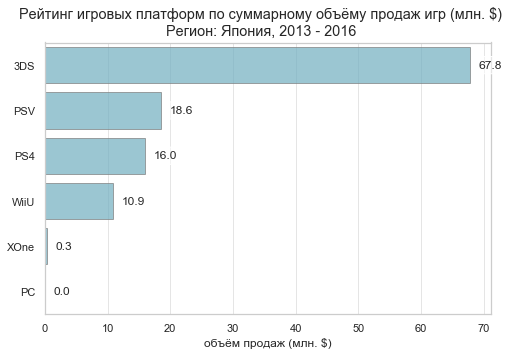

In [89]:
estimation_graph(games_gen8_df, groupby='platform', estimator='sum', 
                 region='jp_sales', figsize=(8,5))

По игровым платформам - очевидные отличия от общемировых тенденций. В Японии популярны портативные консоли 3DS и PSV. За ними следуют PS4 и WiiU. Игры для XBox One и PC вообще не пользуются популярностью в Японии. Их там, фактически, не продаётся. Действительно, зачем нужен XBox, когда в у японцев есть Nintendo и Sony?

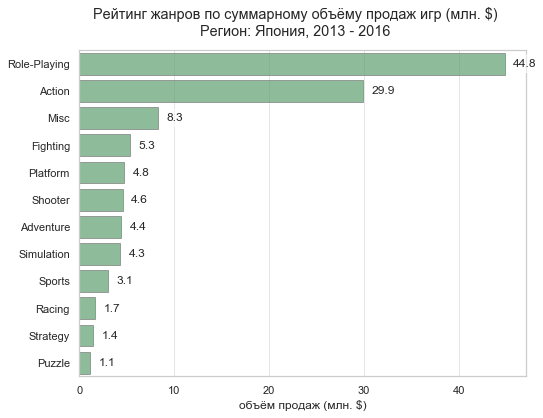

In [90]:
estimation_graph(games_gen8_df, groupby='genre', estimator='sum', region='jp_sales')

In [91]:
values='jp_sales'
print(f'ТОП-10 игр по платформам и жанрам, суммарные продажи в Японии за 2013-2016 гг.')
display(games_sales_rating(games_gen8_df, values=values).sort_values(by=f'{values}_sum', ascending=False).head(10))
print(f'ТОП-10 игр по платформам и жанрам, средние продажи в Японии за 2013-2016 гг.')
display(games_sales_rating(games_gen8_df, values=values).sort_values(by=f'{values}_mean', ascending=False).head(10))

ТОП-10 игр по платформам и жанрам, суммарные продажи в Японии за 2013-2016 гг.


jp_sales_sum  jp_sales_mean  jp_sales_count
platform genre                                                    
3DS      Role-Playing         33.77           0.54              62
         Action               17.09           0.15             116
PSV      Role-Playing          6.84           0.09              78
PS4      Action                5.90           0.04             144
PSV      Action                5.87           0.05             125
3DS      Simulation            4.07           0.27              15
         Misc                  3.81           0.12              32
PS4      Role-Playing          3.55           0.07              51
3DS      Fighting              2.92           0.42               7
PS4      Shooter               2.81           0.07              41

ТОП-10 игр по платформам и жанрам, средние продажи в Японии за 2013-2016 гг.


jp_sales_sum  jp_sales_mean  jp_sales_count
platform genre                                                    
WiiU     Racing                1.28           0.64               2
3DS      Role-Playing         33.77           0.54              62
         Fighting              2.92           0.42               7
         Simulation            4.07           0.27              15
WiiU     Fighting              1.00           0.25               4
         Shooter               1.54           0.19               8
         Platform              2.41           0.16              15
3DS      Action               17.09           0.15             116
WiiU     Strategy              0.29           0.14               2
         Role-Playing          0.67           0.13               5

ТОП-10 игр по суммарным продажам в Японии:

In [92]:
games_gen8_df.sort_values(by='jp_sales', ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
3,pokemon x/pokemon y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,10.25,14.60
58,monster hunter 4,3DS,2013,Role-Playing,0.00,0.00,3.44,0.00,NaN,NaN,unknown,0.00,3.44
64,yokai watch 2 ganso/honke,3DS,2014,Role-Playing,0.09,0.00,3.18,0.01,NaN,NaN,unknown,0.10,3.28
5,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,8.58,11.68
62,monster hunter x,3DS,2015,Action,0.27,0.21,2.79,0.05,NaN,NaN,unknown,0.53,3.32
85,yokai watch 2 shinuchi,3DS,2014,Role-Playing,0.00,0.00,2.68,0.00,NaN,NaN,unknown,0.00,2.68
47,monster hunter 4 ultimate,3DS,2014,Role-Playing,0.68,0.48,2.62,0.11,86.0,8.7,13+,1.27,3.89
13,super smash bros. for wii u and 3ds,3DS,2014,Fighting,3.27,1.37,2.43,0.48,NaN,NaN,unknown,5.12,7.55
97,yokai watch busters,3DS,2015,Action,0.00,0.00,2.29,0.00,NaN,NaN,unknown,0.00,2.29
16,pokemon sun/moon,3DS,2016,Role-Playing,2.98,1.45,2.26,0.45,NaN,NaN,unknown,4.88,7.14


In [93]:
print('ТОП-5 игр для WiiU по продажам в Японии 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == 'WiiU', :].sort_values(by='jp_sales', ascending=False).head(5)

ТОП-5 игр для WiiU по продажам в Японии 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
33,splatoon,WiiU,2015,Shooter,1.54,1.18,1.46,0.26,81.0,8.5,10+,2.98,4.44
17,mario kart 8,WiiU,2014,Racing,3.15,2.15,1.28,0.51,88.0,9.1,everyone,5.81,7.09
70,super mario maker,WiiU,2015,Platform,1.18,0.89,0.94,0.20,88.0,8.7,everyone,2.27,3.21
145,wii party u,WiiU,2013,Misc,0.30,0.56,0.84,0.05,65.0,6.8,everyone,0.91,1.75
27,super smash bros. for wii u and 3ds,WiiU,2014,Fighting,2.60,1.08,0.81,0.38,NaN,NaN,unknown,4.06,4.87


In [94]:
print('ТОП-5 игр для PS4 по продажам в Японии 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == 'PS4', :].sort_values(by='jp_sales', ascending=False).head(5)

ТОП-5 игр для PS4 по продажам в Японии 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
59,metal gear solid v: the phantom pain,PS4,2015,Action,1.09,1.36,0.49,0.48,93.0,8.2,17+,2.93,3.42
149,knack,PS4,2013,Platform,0.43,0.68,0.42,0.20,54.0,6.5,10+,1.31,1.73
4,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,17+,12.24,12.62
339,dragon quest heroes: the world's tree woe and ...,PS4,2015,Action,0.17,0.13,0.37,0.06,NaN,NaN,unknown,0.36,0.73
589,persona 5,PS4,2016,Role-Playing,0.00,0.00,0.37,0.00,NaN,NaN,unknown,0.00,0.37


In [95]:
print('ТОП-5 игр для PSV по продажам в Японии 2013-2016 гг')
games_gen8_df.loc[games_gen8_df.loc[:, 'platform'] == 'PSV', :].sort_values(by='jp_sales', ascending=False).head(5)

ТОП-5 игр для PSV по продажам в Японии 2013-2016 гг


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
123,minecraft,PSV,2014,Misc,0.18,0.64,0.90,0.24,NaN,NaN,unknown,1.06,1.96
507,god eater 2,PSV,2013,Role-Playing,0.00,0.00,0.45,0.00,NaN,NaN,unknown,0.00,0.45
551,god eater 2: rage burst,PSV,2015,Role-Playing,0.00,0.03,0.37,0.01,NaN,8.1,13+,0.04,0.41
381,freedom wars,PSV,2014,Role-Playing,0.15,0.10,0.32,0.08,73.0,8.3,13+,0.33,0.65
674,sword art online: hollow fragment,PSV,2014,Role-Playing,0.00,0.00,0.30,0.00,67.0,7.6,13+,0.00,0.30


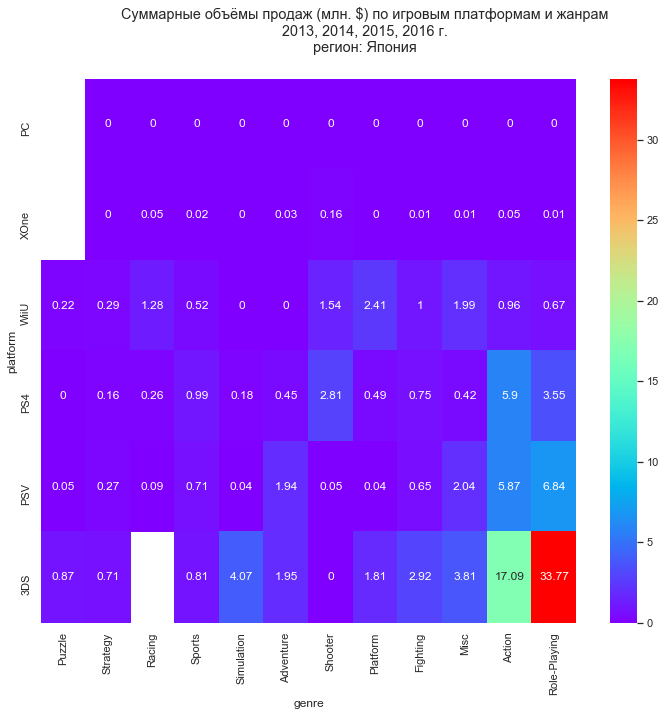

In [96]:
genres_platforms_heatmap(games_gen8_df, region='jp_sales')

Бал в Японии правит **Nintendo 3DS** с **Role-Playing и Action**, а именно - с играми серии **Yokai Watch** (в остальном мире это - малопулярная игра), **Monster Hunter** и **Pokemon**. Остальные жанры и игры сильно отстают по объёмам продаж.

<h2 style="color:DodgerBlue"> Популярные консоли и жанры в Стране восходящего Солнца.</h2>

Япония, очевидно, это другой мир, в том числе и игровой. Никому более неизвестные игры серии Yokai Watch *("Йо-каи основаны на традиционных японских демонах ёкай, но часто с неожиданной подачей. Если герою удаётся подружиться с йо-каем, то он получает от него медаль дружбы, с помощью которой сможет призывать соответствующего йо-кая на помощь в сражениях или для решения проблем." © [Wikipedia](https://ru.wikipedia.org/wiki/Yo-kai_Watch))* имеют там объём продаж более 8 млн. долларов с 2013 по 2016 гг.

В стране восходящего Солнца супер-популярны портативные консоли, в особенности - 3DS. В отличие от остального мира, PSV в Японии не аутсайдер, а занимает по объёмам продаж 2е место. 

**Лучшие сочетания жанр-платформа в Японии по объёмам продаж:** 
- **Nintendo 3DS** с **Role-Playing и Action**, а именно - с играми серии **Yokai Watch, Monster Hunter, Pokemon**. 
- **PSV и PS4 c Action и Role-Playing**
- **Shooter от PS4**.

<h2 style="color:DodgerBlue">3.2 Популярные консоли и жанры. Северная Америка и Европа.</h2>

Основные тенденции должны быть схожими для Европы и Северной Америки. Посмотрим на диаграммы.

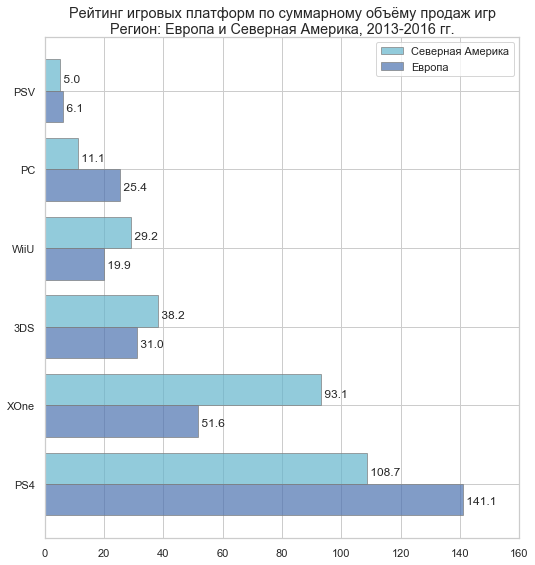

In [97]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

data_na = games_gen8_df.groupby('platform')['na_sales'].sum().sort_values(ascending=False)
data_eu = games_gen8_df.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)


ax.barh(data_na.index, data_na, alpha=0.7,  height=0.4, align='edge', 
        color='c', label='Северная Америка', edgecolor='.5')
ax.barh(data_eu.index, data_eu, alpha=0.7, height=-0.4, align='edge', 
        color='b', label='Европа', edgecolor='.5')
plt.legend()
plt.suptitle("""Рейтинг игровых платформ по суммарному объёму продаж игр
Регион: Европа и Северная Америка, 2013-2016 гг.
""")
plt.xlim(0,160)
for x, y, txt in zip(data_na.values, data_na.index, data_na.values):
    text = f' {round(txt,1)}'
    plt.text(x, y, f'{text}\n\n', va='center')  
xpos = data_eu.values
for x, y, txt in zip(data_eu.values, data_eu.index, data_eu.values):
    text = f'\n {round(txt,1)}'
    plt.text(x, y, f'\n\n{text}', va='center') 

plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

И в Европе и в Северной Америке совсем не популярна PSV. Лидер рейтинга - PS4. XBox One - на 2 месте. Но есть отличия: в Северной Америке, в отличие от Европы, гораздо более популярен XBox One, и гораздо менее - компьютеры.

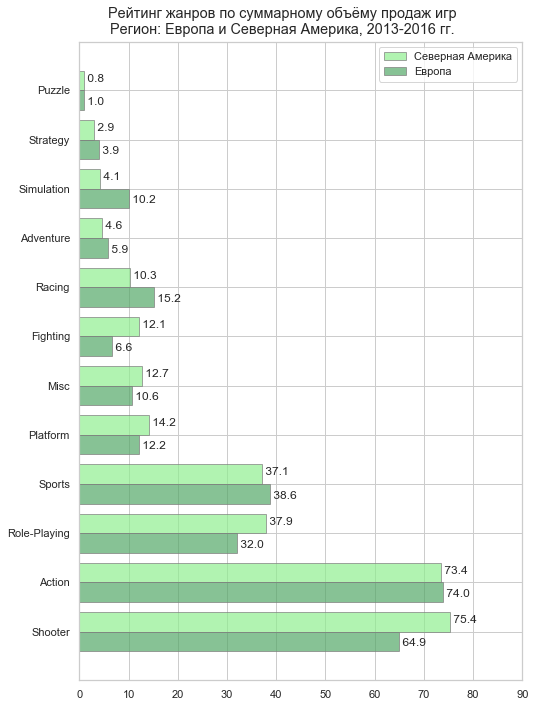

In [98]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))

data_na = games_gen8_df.groupby('genre')['na_sales'].sum().sort_values(ascending=False)
data_eu = games_gen8_df.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)


ax.barh(data_na.index, data_na, alpha=0.7,  height=0.4, align='edge', 
        color='lightgreen', label='Северная Америка', edgecolor='.5')
ax.barh(data_eu.index, data_eu, alpha=0.7, height=-0.4, align='edge', 
        color='g', label='Европа', edgecolor='.5')

plt.legend()

plt.suptitle("""Рейтинг жанров по суммарному объёму продаж игр
Регион: Европа и Северная Америка, 2013-2016 гг.
""")


plt.xlim(0,90)

for x, y, txt in zip(data_na.values, data_na.index, data_na.values):
    text = f' {round(txt,1)}'
    plt.text(x, y, f'{text}\n\n', va='center')  

for x, y, txt in zip(data_eu.values, data_eu.index, data_eu.values):
    text = f' {round(txt,1)}'
    plt.text(x, y, f'\n\n{text}', va='center') 
plt.tight_layout(rect=(0, 0, 0.95, 0.95))
plt.show()

По жанрам картины похожи. И в Европе и в Северной Америке с большим отрывом лидируют Action и Shooter. В Северной Америке Shooter продавались лучше, чем в Европе. За ними следуют RPG и Sports. В Северной Америке их объёмы продаж почти равны, а в Европе Sports опережает RPG. Далее следуют с близкими значениями 4 жанра. 3 из них общие для обоих регионов: Platform, Misc, Racing. А вот Simulation в Европе в 2.5 раза популярнее, чем в Америке. Обратная ситуация с Fighting.

In [99]:
print(f'ТОП-10 рейтинг игр по платформам и жанрам, \nсуммарные продажи в Европе за 2013-2016 гг.')
display(games_sales_rating(games_gen8_df, values='eu_sales').sort_values(by='eu_sales_sum', ascending=False).head(10))
print(f'ТОП-10 рейтинг игр по платформам и жанрам, \nсуммарные продажи в Северной Америке за 2013-2016 гг.')
display(games_sales_rating(games_gen8_df, values='na_sales').sort_values(by='na_sales_sum', ascending=False).head(10))

ТОП-10 рейтинг игр по платформам и жанрам, 
суммарные продажи в Европе за 2013-2016 гг.


eu_sales_sum  eu_sales_mean  eu_sales_count
platform genre                                                    
PS4      Action               42.71           0.30             144
         Shooter              39.16           0.96              41
         Sports               25.98           0.56              46
XOne     Shooter              17.80           0.47              38
         Action               12.58           0.15              85
3DS      Role-Playing         12.34           0.20              62
PS4      Role-Playing         11.96           0.23              51
XOne     Sports                8.73           0.23              38
PS4      Racing                7.45           0.39              19
3DS      Action                6.97           0.06             116

ТОП-10 рейтинг игр по платформам и жанрам, 
суммарные продажи в Северной Америке за 2013-2016 гг.


na_sales_sum  na_sales_mean  na_sales_count
platform genre                                                    
XOne     Shooter              36.86           0.97              38
PS4      Action               32.83           0.23             144
         Shooter              32.66           0.80              41
XOne     Action               21.37           0.25              85
PS4      Sports               19.78           0.43              46
3DS      Role-Playing         18.42           0.30              62
XOne     Sports               15.59           0.41              38
PS4      Role-Playing          9.34           0.18              51
3DS      Action                8.60           0.07             116
WiiU     Platform              7.64           0.51              15

In [100]:
print('ТОП-5 игр по суммарным продажам в Европе:')
games_gen8_df.sort_values(by='eu_sales', ascending=False).head(5)

ТОП-5 игр по суммарным продажам в Европе:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
4,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,17+,12.24,12.62
9,fifa 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,everyone,8.52,8.58
2,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.27,14.63
12,fifa 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,everyone,7.52,7.60
19,fifa 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82.0,5.7,everyone,6.03,6.08


In [101]:
print('ТОП-5 игр по суммарным продажам в Северной Америке:')
games_gen8_df.sort_values(by='na_sales', ascending=False).head(5)

ТОП-5 игр по суммарным продажам в Северной Америке:


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,not_jp_sales,global_sales
2,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.27,14.63
3,pokemon x/pokemon y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,10.25,14.60
14,call of duty: black ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,unknown,7.38,7.39
5,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,8.58,11.68
4,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,17+,12.24,12.62


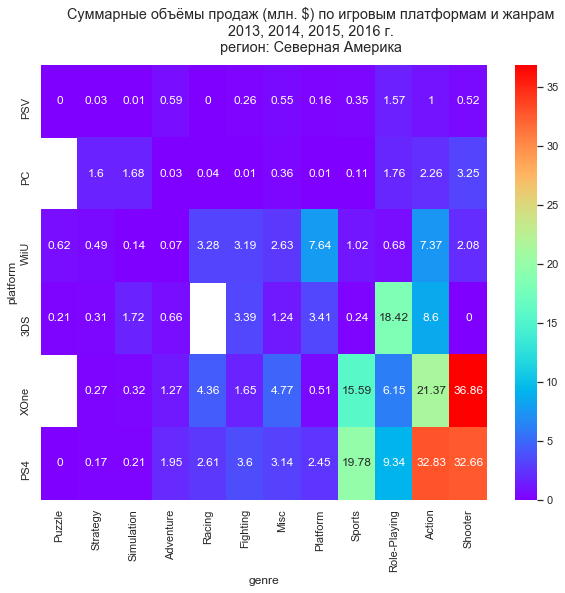

In [102]:
genres_platforms_heatmap(games_gen8_df, region='na_sales', figsize=(10,8))

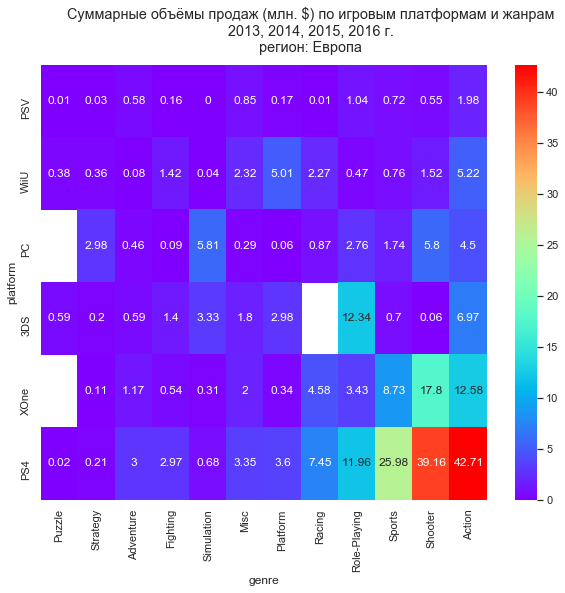

In [103]:
genres_platforms_heatmap(games_gen8_df, region='eu_sales', figsize=(10,8))

<h2 style="color:DodgerBlue"> Популярные консоли и жанры в Северной Америке и Европе</h2>

В комбинации **жанр-платформа** и в Европе и в Америке выделяется: 
- PS4 + Action, Shooter, Sport
- 3DS + Role-Playing

Есть отличия: по тепловой карте видно, насколько в Америке популярнее XBox. XBox+Action, Shooter, Sport в Америке - это в 2 раза больше продаж, чем в Европе. Зато Action на PS4 в Европе гораздо популярнее, чем в Америке.

И в Европе и в Северной Америке лидер по объёмам продаж - PS4. XBox One - на 2 месте. При этом в Северной Америке, в отличие от Европы, он гораздо более популярен. А вот продажи компьютерных (PC) игр в Европе более чем в 2 раза выше, чем в Америке.

И в Европе и в Северной Америке с большим отрывом лидируют Action и Shooter. За ними следуют RPG и Sports. В Европе Sports опережает RPG. Далее следуют с близкими значениями 4 жанра. 3 из них общие для обоих регионов: Platform, Misc, Racing. А вот Simulation в Европе в 2.5 раза популярнее, чем в Америке. Обратная ситуация с Fighting.

<h2 style="color:DodgerBlue">3.3 Влияние рейтинга ESRB на объёмы продаж.</h2>

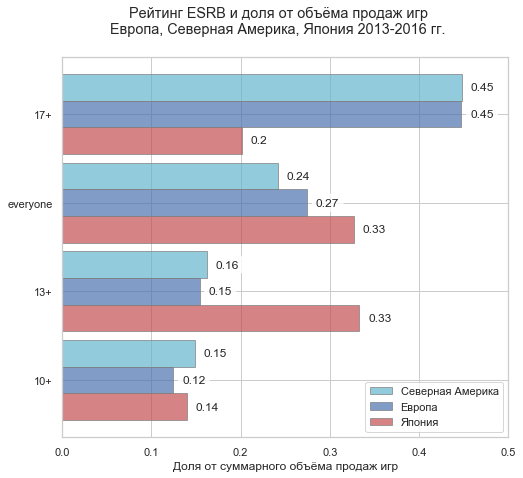

In [104]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))

grpby_esrb = games_gen8_df[games_gen8_df['rating'] != 'unknown'].groupby('rating')
not_grpby = games_gen8_df[games_gen8_df['rating'] != 'unknown']

data_na = (grpby_esrb['na_sales'].sum()/not_grpby['na_sales'].sum()).sort_values(ascending=False)
data_eu = (grpby_esrb['eu_sales'].sum()/not_grpby['eu_sales'].sum()).sort_values(ascending=False)
data_jp = (grpby_esrb['jp_sales'].sum()/not_grpby['jp_sales'].sum()).sort_values(ascending=False)

order_dict = {'10+': 0, '13+': 1, 'everyone': 2, '17+': 3}

order_na = [order_dict[rate]+0.6 for rate in data_na.index]
order_eu = [order_dict[rate]+0.3 for rate in data_eu.index]
order_jp = [order_dict[rate] for rate in data_jp.index]

ax.barh(order_na, data_na, alpha=0.7,  height=0.3, align='center', 
        color='c', label='Северная Америка', edgecolor='.5')
ax.barh(order_eu, data_eu, alpha=0.7, height=0.3, align='center', 
        color='b', label='Европа', edgecolor='.5')
ax.barh(order_jp, data_jp, alpha=0.7, height=0.3, align='center', 
        color='r', label='Япония', edgecolor='.5')
plt.legend()
plt.suptitle("""Рейтинг ESRB и доля от объёма продаж игр
Европа, Северная Америка, Япония 2013-2016 гг.
""")

for x, y, txt in zip(data_na.values, order_na, data_na.values):
    plt.text(x+0.01, y, f'{round(txt,2)}', verticalalignment='center', bbox=dict(boxstyle='round', fc=(1, 1, 1, 0.8)))  

for x, y, txt in zip(data_eu.values, order_eu, data_eu.values):
    plt.text(x+0.01, y, f'{round(txt,2)}', verticalalignment='center', bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.8))) 

for x, y, txt in zip(data_jp.values, order_jp, data_jp.values):
    plt.text(x+0.01, y, f'{round(txt,2)}', verticalalignment='center', bbox=dict(boxstyle="round", fc=(1, 1, 1, 0.8))) 

    
plt.xlim(0,0.5)
plt.xlabel('Доля от суммарного объёма продаж игр')
plt.yticks(order_eu, ('17+', 'everyone', '13+', '10+'))
plt.show()

По объёмам продаж в зависимости от рейтинга ESRB Европа и Америка отличаются мало, тенденции схожи. Почти половина объёмов продаж приходится на игры 17+, за ними следуют игры "для всех", далее - игры 13+ и 10+.
В Японии ситуация иная: одинаковые объёмы продаж - у игр "для всех" и 13+. Игры 17+ гораздо менее популярны, нежели в Европе и Северной Америке.

Думаю, дело тут не в рейтинге, а в том, какие предпочтения у аудитории. Из предыдущего анализа видно, что в Европе и Америке популярны Shooter и Action. Это как раз 17+. А у японцев иные тренды: покемоны, герои аниме и фольклора. Странно присваивать 17+ таким играм. Так что признак ESRB - скорее вторичный.

<h1 style="color:SteelBlue">4. Анализ предпочтений пользователей</h1>

<h2 style="color:DodgerBlue">4.1 Влияние отзывов пользователей и критиков на продажи</h2>

Проведённый ранее [корреляционный анализ](#1.3-Расчёт-недостающих-признаков) показал слабую линейную связь между мировыми объёмами продаж и отзывами критиков везде, кроме Японии. Повторю анализ для актуального периода. Посмотрю на диаграммы рассеяния. Построю тепловую карту корреляций для удобства.

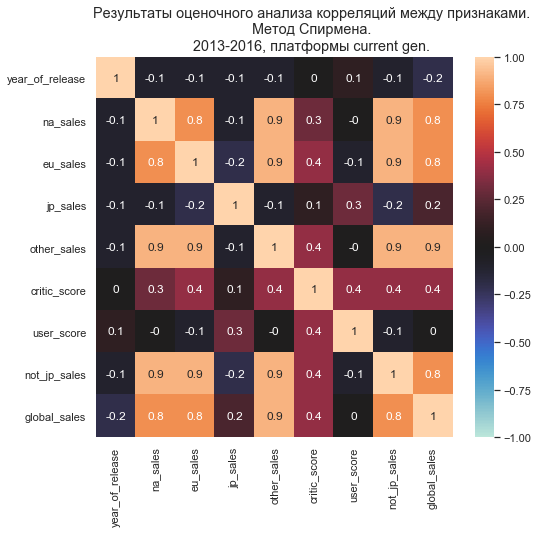

In [105]:
plt.figure(figsize=(8,7))
sns.heatmap(games_gen8_df.corr(method='spearman').round(1), center=0, vmin=-1, vmax=1, annot=True)
plt.suptitle(f"""Результаты оценочного анализа корреляций между признаками.
Метод Спирмена.
2013-2016, платформы current gen.
""")
plt.show()

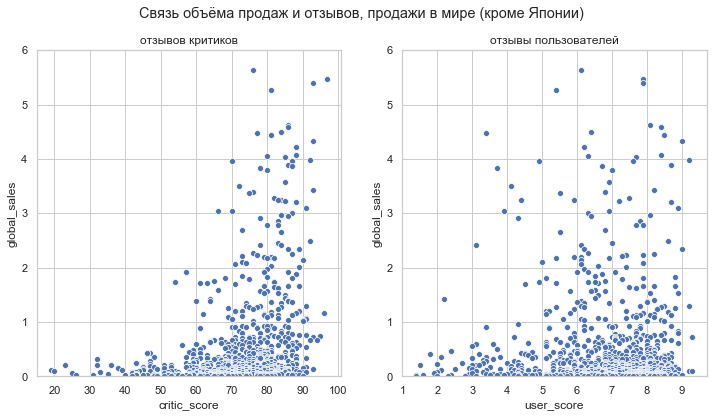

In [106]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.scatterplot(y='global_sales', x='critic_score',
                   data=games_gen8_df)
plt.title("отзывов критиков")
plt.ylim(0, 6)
plt.subplot(122)
sns.scatterplot(y='global_sales', x='user_score',
                   data=games_gen8_df)
plt.title("отзывы пользователей")
plt.ylim(0, 6)
plt.suptitle("Связь объёма продаж и отзывов, продажи в мире (кроме Японии)")
plt.show()

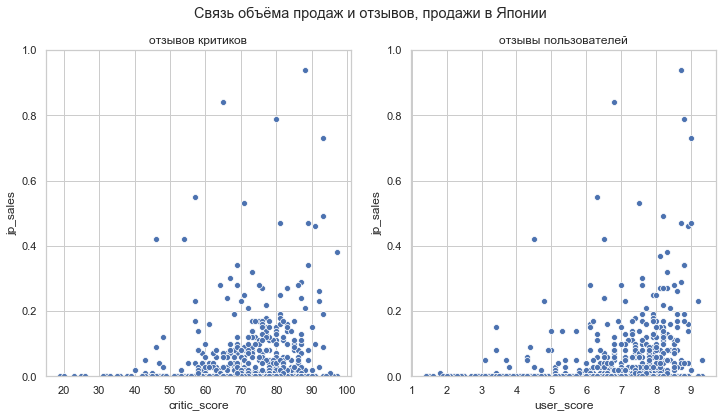

In [107]:
plt.figure(figsize=(12,6))
plt.subplot(121)
sns.scatterplot(y='jp_sales', x='critic_score',
                   data=games_gen8_df)
plt.title("отзывов критиков")
plt.ylim(0, 1)
plt.subplot(122)
sns.scatterplot(y='jp_sales', x='user_score',
                   data=games_gen8_df)
plt.title("отзывы пользователей")
plt.ylim(0, 1)
plt.suptitle("Связь объёма продаж и отзывов, продажи в Японии")
plt.show()

<h2 style="color:DodgerBlue"> Результаты анализа взаимосвязей продаж с оценками критиков и пользователей</h2>

Слабая связь определённо прослеживается, и не только в корреляционном анализе, но и визуально. Корреляционный анализ показывает слабую линейную связь между оценками критиков и объёмами продаж по всему миру, а для Японии - аналогичную связь между объёмами продаж и отзывами пользователей (коэффициенты 0.4 и 0.3). По диаграммам рассеяния, однако, видно, что картины по отзывам критиков схожи как для Японии, так и для остальных регионов мира. Игры с большими объёмами продаж редко получают низкие баллы у критиков. У пользователей, правда, такие ситуации встречаются чаще, особенно - вне Японии. Возможно, играет роль несоответствие ожиданий реальности, когда покупаешь успешную игру и получаешь совсем не то, чего ожидал. Игры с малыми объёмами продаж также вполне могут иметь высокие баллы, поэтому связь именно слабая.

**При прогнозе успешности вряд ли можно уверенно использовать высокий балл как гарантию успеха. Однако насчёт низких баллов тенденция более ясная (верхняя граница диаграмм рассеяния): игры с низкими оценками критиков редко имеют большие объёмы продаж.**

<h2 style="color:DodgerBlue"> 4.2 Любимые жанры и платформы: оценки критиков и пользователей</h2>

Поскольку нет возможности из данных понять, кто ставил оценку - критик из Японии, Северной Америки или Европы, то анализ буду проводить по всему миру.

Предполагал, что можно выделить ТОП игр по оценкам пользователей и критиков, но выяснилось, что таких оценок немного и их воспроизводимость под большим сомнением. Например, максимальное число оценок критиков для одной игры составляет 4, а пользовательских оценок - 6. Понятно, что, по сравнению с числом проданных копий каждой игры, это ничтожно мало.

In [108]:
print('Количество оценок критиков по играм:')
games_gen8_df.groupby('name')['critic_score'].count().sort_values(ascending=False).head(5).reset_index()

Количество оценок критиков по играм:


,name,critic_score
0,watch dogs,4
1,terraria,4
2,lego marvel's avengers,4
3,lego jurassic world,4
4,the lego movie videogame,4


In [109]:
print('Количество оценок пользователей по играм:')
games_gen8_df.groupby('name')['user_score'].count().sort_values(ascending=False).head(5).reset_index()

Количество оценок пользователей по играм:


,name,user_score
0,lego batman 3: beyond gotham,6
1,lego jurassic world,6
2,the lego movie videogame,6
3,fifa 15,5
4,angry birds star wars,5


А вот если рассматривать оценки игр по платформам и жанрам, то дела обстоят лучше. Хотя ряд жанров оценен недостаточно. Больше всего оценок у жанров из ТОПа: Action, Shooter, RPG, Sports. 

In [110]:
print('Количество оценок критиков и пользовтелей по жанрам:')
games_gen8_df.groupby('genre')[['critic_score', 
                           'user_score']].count().sort_values(by='critic_score', ascending=False).reset_index()

Количество оценок критиков и пользовтелей по жанрам:


,genre,critic_score,user_score
0,Action,251,285
1,Shooter,101,102
2,Role-Playing,97,100
3,Sports,90,101
4,Racing,44,45
5,Platform,43,45
6,Adventure,42,48
7,Misc,39,39
8,Fighting,26,27
9,Simulation,24,27


In [111]:
print('Количество оценок критиков и пользователей по игровым платформам:')
games_gen8_df.groupby('platform')[['critic_score', 
                           'user_score']].count().sort_values(by='critic_score', ascending=False).reset_index()

Количество оценок критиков и пользователей по игровым платформам:


,platform,critic_score,user_score
0,PS4,252,257
1,XOne,169,182
2,PC,149,155
3,PSV,77,99
4,3DS,71,80
5,WiiU,70,80


Рассмотрим усреднённые оценки критиков и пользователей для жанров и платформ, а затем - тепловую карту.

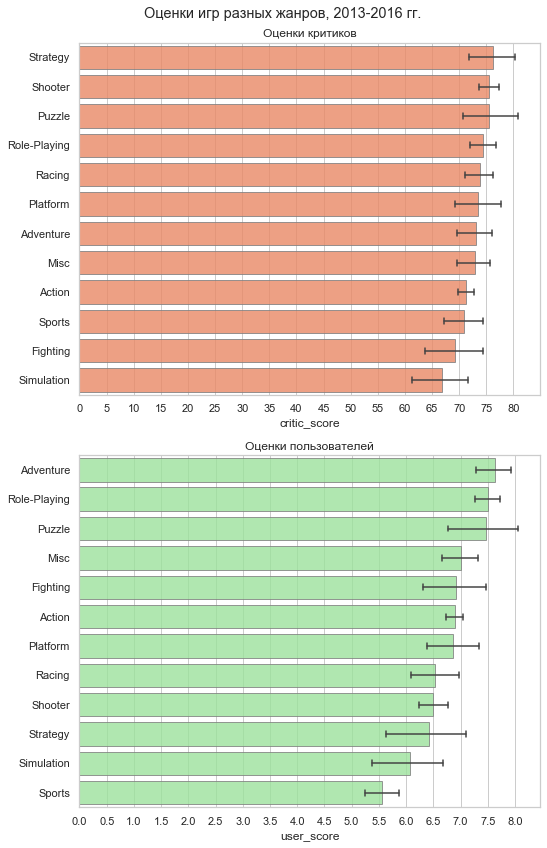

In [112]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,12))
ax[0].set_title('Оценки критиков')
ax[1].set_title('Оценки пользователей')
sorted_critic_list = games_gen8_df.groupby('genre')['critic_score'].mean().sort_values(ascending=False).index
sorted_user_list = games_gen8_df.groupby('genre')['user_score'].mean().sort_values(ascending=False).index
ax[0].set_xticks(range(0,90,5))
ax[1].set_xticks(np.arange(0,9,0.5))
sns.barplot(ax=ax[0], y='genre', x='critic_score', data=games_gen8_df,
            color='coral', alpha=0.8, edgecolor='.5',
            estimator=np.mean, capsize=0.2, errwidth=1.5,
            order=sorted_critic_list)

sns.barplot(ax=ax[1], y='genre', x='user_score', data=games_gen8_df,
            color='lightgreen', alpha=0.8, edgecolor='.5',
            estimator=np.mean, capsize=0.2, errwidth=1.5,
            order=sorted_user_list)

for axs in ax:
    axs.set_ylabel('')
plt.suptitle('Оценки игр разных жанров, 2013-2016 гг.')
plt.tight_layout(rect=(0, 0, 0.97, 0.97))
plt.show()

На столбчатых диаграммах видна большая вариабельность. При этом различия в пользовательских оценках значительно выше, чем в оценках критиков.

Судя по бутстрап-разбросу, есть отличия между средними оценками критиков у Shooters и Action, Shooters и Simulation. Остальные усредненные оценки имеют значительную вариабельность, доверительные интервалы пересекаются.

Среди пользовательских оценок есть абсолютный аутсайдер - жанр "Спорт". Топ-3 составляют Паззлы, Приключения и Ролевые игры.   

На самом деле, интересно соотнести предпочтения пользователей и критиков не со всеми жанрами, а с жанрами из ТОПа по объёмам продаж: 'Action', 'Shooter', 'Role-Playing', 'Sports'

In [113]:
genre_top_list = ['Action', 'Shooter', 'Role-Playing', 'Sports']

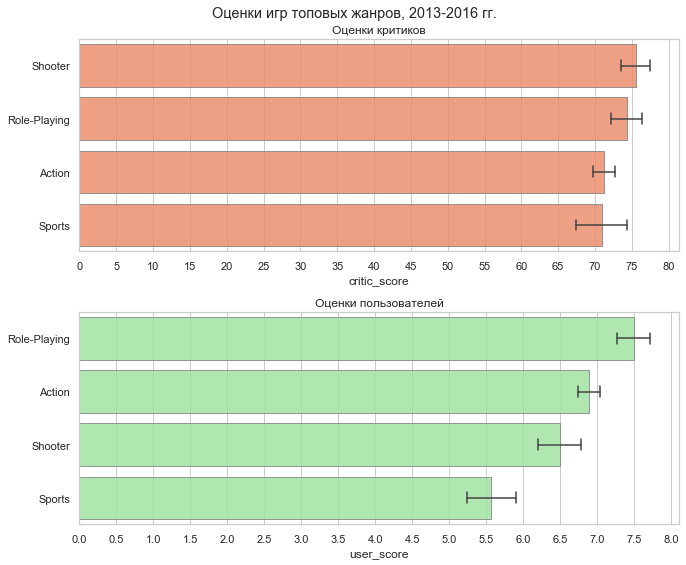

In [114]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
gen8_topgenre_df = games_gen8_df.loc[games_gen8_df.loc[:, 'genre'].isin(genre_top_list), :]
ax[0].set_title('Оценки критиков')
ax[1].set_title('Оценки пользователей')
ax[0].set_xticks(range(0,90,5))
ax[1].set_xticks(np.arange(0,9,0.5))

sorted_critic_list = gen8_topgenre_df.groupby('genre')['critic_score'].mean().sort_values(ascending=False).index
sorted_user_list = gen8_topgenre_df.groupby('genre')['user_score'].mean().sort_values(ascending=False).index

sns.barplot(ax=ax[0], y='genre', x='critic_score', data=gen8_topgenre_df,
            color='coral', alpha=0.8, edgecolor='.5',
            estimator=np.mean, capsize=0.2, errwidth=1.5,
            order=sorted_critic_list)

sns.barplot(ax=ax[1], y='genre', x='user_score', data=gen8_topgenre_df,
            color='lightgreen', alpha=0.8, edgecolor='.5',
            estimator=np.mean, capsize=0.2, errwidth=1.5,
            order=sorted_user_list)

for axs in ax:
    axs.set_ylabel('')

plt.suptitle('Оценки игр топовых жанров, 2013-2016 гг.')
plt.tight_layout(rect=(0, 0, 0.97, 0.97))
plt.show()

Sport - последний из топовых жанров как у критиков, так и у пользователей. Судя по 95% бутстрап-интервалу, шутеры и ролевые игры бычно превосходят action и sports по мнению критиков.

В оценках пользователей больше определённости. Первое место - Role Playing, за ним - Action и Shooter. Sports - замыкающий.

Проверю гипотезу о том, что между средними пользовательскими оценками нет значимых различий. Использую ANOVA и затем AB тест.

- H0: между средними пользовательскими оценками игр топовых жанров нет различий
- H1: различия есть. Средние следуют в порядке Role Playing, Action, Shooter, Sports.
- alpha = 0.05

In [115]:
uscore_data_dict = {}
for genre in genre_top_list:
    uscore_data_dict[genre] = gen8_topgenre_df.loc[(gen8_topgenre_df.loc[:, 'genre'] == genre) &
                                                   (~gen8_topgenre_df.loc[:, 'user_score'].isna()),                                                   
                                                   'user_score']

In [116]:
print('Проверка гипотез о нормальном характере распределения\nпользовательских оценок игр топовых жанров:\n')
print("""
H0 - распределения являются нормальными
H1 - распределения отличаются от нормальных
Уровень значимости alpha приму равным 5% alpha= 0.05
     """)

for genre in genre_top_list:
    print(f'{genre}, pvalue={round(stats.normaltest(uscore_data_dict[genre]).pvalue, 4)}')

Проверка гипотез о нормальном характере распределения
пользовательских оценок игр топовых жанров:


H0 - распределения являются нормальными
H1 - распределения отличаются от нормальных
Уровень значимости alpha приму равным 5% alpha= 0.05
     
Action, pvalue=0.0
Shooter, pvalue=0.0136
Role-Playing, pvalue=0.0
Sports, pvalue=0.081


Нет оснований отвергнуть гипотезу о нормальности распределения оценок пользователей только для Sports. У остальных жанров p < alpha. Поэтому воспользуюсь перестановочными тестами. Классические тесты (f-статистику и t-тест) использую для валидации результатов.

In [117]:
result = ANOVA_permutation_test(
    genre_dict['Platform'], 
    uscore_data_dict['Role-Playing'],
    uscore_data_dict['Action'],
    uscore_data_dict['Shooter'],
    uscore_data_dict['Sports']
    )

classic_result = stats.f_oneway(
    genre_dict['Platform'], 
    uscore_data_dict['Role-Playing'],
    uscore_data_dict['Action'],
    uscore_data_dict['Shooter'],
    uscore_data_dict['Sports']
    )
print('H0: между средними пользовательскими оценками игр топовых жанров нет различий')
print(result)
print('\nПроверка перестановочного теста классической one-way f-ANOVA:')
print(classic_result)

if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha={alpha}, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha={alpha}, pvalue={result.pvalue}')

H0: между средними пользовательскими оценками игр топовых жанров нет различий
ANOVA_PermutationResult(f_statistic=378.97672884453954, iterations=10000, pvalue=0.0)

Проверка перестановочного теста классической one-way f-ANOVA:
F_onewayResult(statistic=378.97672884453965, pvalue=5.1793229909292533e-169)

Отвергаем нулевую гипотезу: alpha=0.05, pvalue=0.0


Как и следовало ожидать, между средними пользовательскими оценками топовых жанров есть статистически значимые отличия (alpha=0.05). Единственная пара, по которой есть вопросы - Action-Shooter. Для остальных доверительные интервалы даже не пересекаются. 

Проверю. Множественные сравнения проводить не буду, поэтому поправку не использую.

In [118]:
a = uscore_data_dict['Shooter']
b = uscore_data_dict['Action']
result = AB_permutation_test(a, b)
classic_result = stats.ttest_ind(a, b)

print('H0: между средними пользовательскими оценками игр Shooter и Action нет различий')
print(result)
print('\nПроверка перестановочного классическим t-тестом:')
print(classic_result)

if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')

H0: между средними пользовательскими оценками игр Shooter и Action нет различий
AB_PermutationResult(means_difference=-0.39479876160990734, iterations=10000, pvalue=0.0109)

Проверка перестановочного классическим t-тестом:
Ttest_indResult(statistic=-2.502991510707887, pvalue=0.012728317082298999)

Отвергаем нулевую гипотезу: alpha=0.05, pvalue=0.0109


Итак, между пользовательскими оценками топовых жанров есть значимые различия при alpha=0.05. Причём жанры значимо расположены в следующем порядке по убыванию оценок пользователей:

In [119]:
for genre in ['Role-Playing', 'Action', 'Shooter', 'Sports']:
    err = 2*uscore_data_dict[genre].std() / np.sqrt(len(uscore_data_dict[genre]))
    print(f'{genre}, user score = {round(uscore_data_dict[genre].mean(), 2)} +/- {round(err, 2)}')

Role-Playing, user score = 7.5 +/- 0.22
Action, user score = 6.89 +/- 0.16
Shooter, user score = 6.5 +/- 0.29
Sports, user score = 5.57 +/- 0.33


Интересно, что в целом оценки и продажи связаны мало. Например, паззлы, которые нравятся пользователям, продаются и выпускаются малыми объёмами. Видимо, имеет место оценка истинных ценителей. К тому же, жанры, которые популярны и хорошо продаются, являются заложниками собственной популярности: от них ждут слишком многого и больше разочаровываются. Ещё стоит отметить, что оценивают, конечно, не жанры, а игры. И тут многое зависит от консоли и названия игры.

Посмотрю на оценки игр для различных платформ. Есть ли фавориты?

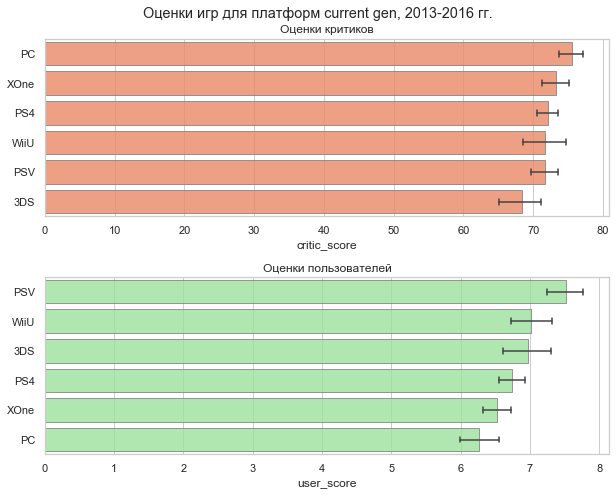

In [120]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(9,7))
ax[0].set_title('Оценки критиков')
ax[1].set_title('Оценки пользователей')
sorted_critic_list = games_gen8_df.groupby('platform')['critic_score'].mean().sort_values(ascending=False).index
sorted_user_list = games_gen8_df.groupby('platform')['user_score'].mean().sort_values(ascending=False).index

sns.barplot(ax=ax[0], y='platform', x='critic_score', data=games_gen8_df,
            color='coral', alpha=0.8, edgecolor='.5',
            estimator=np.mean, capsize=0.2, errwidth=1.5,
            order=sorted_critic_list)
sns.barplot(ax=ax[1], y='platform', x='user_score', data=games_gen8_df,
            color='lightgreen', alpha=0.8, edgecolor='.5',
            estimator=np.mean, capsize=0.2, errwidth=1.5,
            order=sorted_user_list)

plt.suptitle('Оценки игр для платформ current gen, 2013-2016 гг.')
for axs in ax:
    axs.set_ylabel('')
plt.tight_layout(rect=(0, 0, 0.97, 0.97))
plt.show()

И вновь оценки критиков очень близки. Тем не менее, видно, что PC превосходит PS4, PSV и 3DS. Это мало помогает в продажах играм для PC.

По оценкам пользователей на 1 месте PSV. Очень интересно, учитывая, что эта платформа по объёмам продаж - последняя. Возможно, пользователи не связаны излишними ожиданиями, когда покупают недорогие игры PSV и менее требовательны? Или это японцы, у которых PSV популярна, усиленно "топят" за неё? По оценкам пользователей PC и XBox One - в хвосте топа.

Проверю, значимо ли PC хуже, чем XOne:

In [121]:
a = games_gen8_df.loc[(games_gen8_df.loc[:, 'platform'] == 'PC') &
                      (~games_gen8_df.loc[:, 'user_score'].isna()), 'user_score']
b = games_gen8_df.loc[(games_gen8_df.loc[:, 'platform'] == 'XOne') &
                      (~games_gen8_df.loc[:, 'user_score'].isna()), 'user_score']

result = AB_permutation_test(a, b)
classic_result = stats.ttest_ind(a, b)

print('H0: между средними пользовательскими оценками игр для PC и XBox One нет различий')
print(result)
print('\nПроверка перестановочного классическим t-тестом:')
print(classic_result)
if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')

H0: между средними пользовательскими оценками игр для PC и XBox One нет различий
AB_PermutationResult(means_difference=-0.2517511520737328, iterations=10000, pvalue=0.1364)

Проверка перестановочного классическим t-тестом:
Ttest_indResult(statistic=-1.4788255981357277, pvalue=0.14012658403611647)

Нет оснований отвергать нулевую гипотезу: alpha=0.05, pvalue=0.1364


Статистический анализ показывает, что значимых отличий при alpha=0.05 в пользовательском рейтинге PC и XBox нет. Поэтому назвать PC однозначным аутсайдером рейтинга нельзя.

А есть ли разница в рейтингах портативных консолей 3DS и PSV?

In [122]:
a = games_gen8_df.loc[(games_gen8_df.loc[:, 'platform'] == 'PSV') &
                      (~games_gen8_df.loc[:, 'user_score'].isna()), 'user_score']
b = games_gen8_df.loc[(games_gen8_df.loc[:, 'platform'] == '3DS') &
                      (~games_gen8_df.loc[:, 'user_score'].isna()), 'user_score']

result = AB_permutation_test(a, b)
classic_result = stats.ttest_ind(a, b)

print('H0: между средними пользовательскими оценками игр для PSV и 3DS нет различий')
print(result)
print('\nПроверка перестановочного классическим t-тестом:')
print(classic_result)
if result.pvalue < alpha:
    print(f'\nОтвергаем нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')
else:
    print(f'\nНет оснований отвергать нулевую гипотезу: alpha={alpha:.2f}, pvalue={result.pvalue}')

H0: между средними пользовательскими оценками игр для PSV и 3DS нет различий
AB_PermutationResult(means_difference=0.551022727272727, iterations=10000, pvalue=0.012)

Проверка перестановочного классическим t-тестом:
Ttest_indResult(statistic=2.575556727991514, pvalue=0.010824543981942096)

Отвергаем нулевую гипотезу: alpha=0.05, pvalue=0.012


А вот между пользовательскими рейтингами игр для 3DS и PSV значимые отличия есть (alpha=0.05, pvalue=0.0094). PSV - статистически значимый лидер.

На мой взгляд, рассматривать консоли и жанры в отрыве друг от друга некорректно. Поэтому предлагаю взглянуть на пары консоль-жанр и выделить среди них лидеров рейтинга.

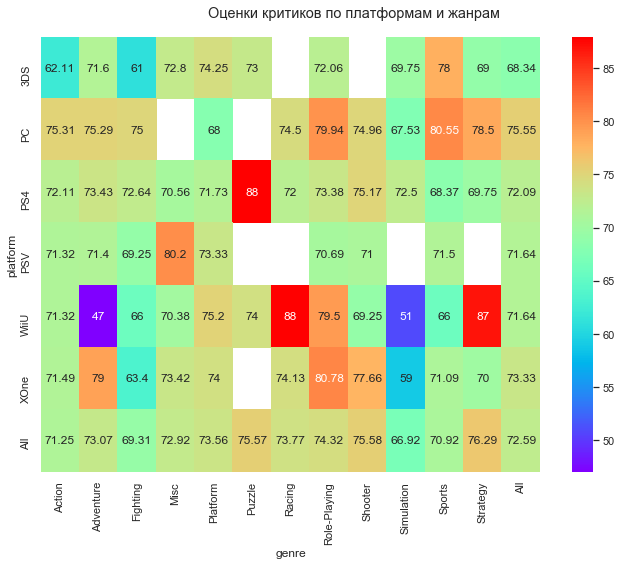

In [123]:
scores_heatmap(games_gen8_df)

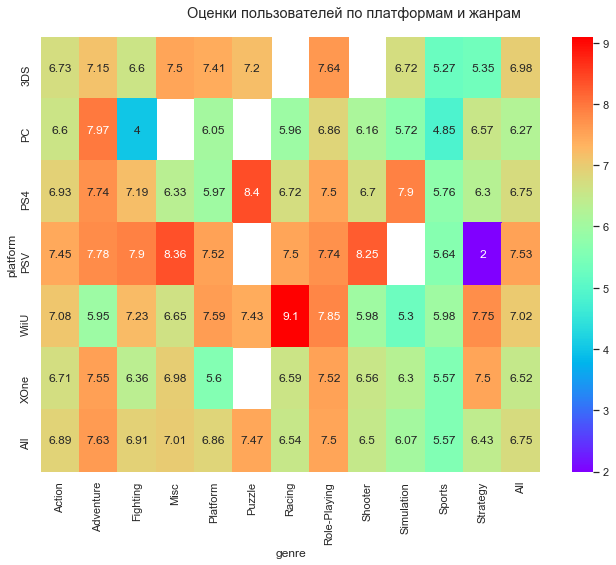

In [124]:
scores_heatmap(games_gen8_df, values='user_score')

И вот что получается: и критики, и пользователи выделяют **Racing на WiiU, Puzzle на PS4 и Misc на PSV.** Не такие уж разные предпочтения, как могло бы показаться на основе анализа усреднённых данных.

Аутсайдеры по рейтингу пользователей: стратегии на PSV (действительно, несколько странное сочетание) и Fighting на PC.

Аутсайдеры по мнению критиков: Simulation и Adventure на WiiU. (для стратегий на PSV нет данных, а вот Fighting'и для PC у критиков получали в среднем неплохие баллы)

<h2 style="color:DodgerBlue"> Результаты анализа оценок пользователей и критиков</h2>

Различия в пользовательских оценках значительно выше, чем в оценках критиков.

Критики выделяют Shooters. В топ жанров Shooters значимо выше оцениваются критиками, чем Action и Sports. Остальные усредненные оценки имеют значительную вариабельность, доверительные интервалы пересекаются.

В оценках пользователей больше определённости. Абсолютный аутсайдер - жанр "Спорт". Топ-3 составляют Паззлы, Приключения и Ролевые игры. Если рассмотреть жанры из топа объёмов продаж - Action, Shooter, RPG, Sports, то первое место - Role Playing, за ним - Action и Shooter. Sports - замыкающий. Обнаружены значимые различия с уровнем значимости alpha=0.05 между средними Action, Shooter, RPG, Sports (использован перестановочный дисперсионный анализ). Причём показано AB тестом (перестановочны тест разности средних), что средний рейтинг Action выше, чем Shooter, а значит, рейтинг статистически значимый. Опять же, неясно, как это может помочь в построении прогноза, т.к. продажи слабо связаны с рейтингом, но факт интересный.

Оценки консолей у критиков очень близки. Тем не менее, видно, что PC превосходит PS4, PSV и 3DS. 

По оценкам пользователей на 1 месте PSV. Очень интересно, учитывая, что эта платформа по объёмам продаж - последняя. По оценкам пользователей PC и XBox One - в хвосте топа. Статистический анализ не показал значимых различий в пользовательских рейтингах PC и XBox, так что выделить аутсайдера однозначно нельзя. А вот между пользовательскими рейтингами игр для 3DS и PSV значимые отличия есть (alpha=0.05, pvalue=0.0094). PSV - статистически значимый лидер. За ним идут WiiU и 3DS. Однако, рейтинг не помогает играм для PSV обеспечивать высокие объёмы продаж.

Анализ пар консоль-жанр выделил лидеров как у критиков, так и у пользователей. Это:
- Racing на WiiU
- Puzzle на PS4
- Misc на PSV

Антирейтинг пользователей:
- стратегии для PSV
- Fighting для PC

Антирейтинг критиков:
- Simulation и Adventure на WiiU


<h1 style="color:SteelBlue; font-size:200%">Признаки успешности компьютерных игр. Результаты анализа</h1>

В анализе использованы данные 2013-2016 годов. Время, когда польностью вошли в свои права консоли *current generation:* **WiiU, PlayStation 4, XBox One, Nintendo 3DS, PayStation Vita, PC**. Это те консоли, на которые нужно ориентироваться при разработке рекламных кампаний.

**Важные моменты:**
- Время жизни консоли (время, когда на неё выпускаются игры) составляет в среднем 4.4-7.9 лет. 
- Объём продаж игр для новых консолей нарастает в первые 4-6 лет, затем наблюдается спад, часто - довольно резкий. **Так что в рекламе лучше ориентироваться на молодые консоли, которым не более 4 лет, и игры для них.**


**Основные наблюдения, которые получены в анализе:**
- **успех игры определяется часто не консолью или жанром, а именем**. Есть игры "must have". Mario, Pokemon, Call of Duty, GTA, fallout, FIFA. Они очень здорово тянут платформы, на которых популярны.
- **жанр и платформу лучше рассматривать в связке и при построении рекламной кампании учитывать их совместно. не делать упор на абстрактные Shooter, Action или консоли.**
- рынки Японии, Северной Америки и Европы отличаются. Япония стоит особняком. **При планировании рекламной кампании необходимо учитывать особенности региона**

**Анализ мирового рынка в целом показал, что:**

- **В сочетании жанр-платформа по суммарным мировым продажам однозначно выделяются:**
    - Action и Shooter для PS4
    - RPG для 3DS
    - Shooter для XBox One 
    - Sports для PS4


- **ТОП-5 игр PS4 и XBox** - классика жанров shooters, action, sports, RPG: Call of Duty, GTA, FIFA, fallout.


- **ТОП-5 WiiU** - racing, fighting, shooter, platform. Но всё это - Марио, покемоны и splatoon.


- **ТОП-5 3DS** представлен покемонами и симулятором жизни tomodachi life. RPG, Fighting, Simulation.


- **Рейтинг по суммарному объёму продаж среди консолей:**
    - **PS4** 314.1 млн. долл.
    - **XBox One и 3DS** 159.3 и 143.3 млн. долл.
    - **WiiU** с более чем двукратным отставанием от 3DS 64.6 млн. долл.
    - **PC и PSV** 39.4 и 33 млн. долл



**Исследование рынков Японии, Северной Америки и Европы** чётко показало, что Япония - самобытный и большой рынок.

Cредние объёмы продаж игр 2013-2016, все платформы: 

- в Европе: 0.17  +/- 0.024 млн. долл.
- в Северной Америке: 0.18 +/- 0.024 млн. долл.
- в Японии: 0.07 +/- 0.013 млн. долл.
- в других регионах: 0.05 +/- 0.007 млн. долл.

Суммарные объёмы продаж игр 2013-2016, все платформы: 
- в Европе: 274.95 млн. долл.
- в Северной Америке: 285.42 млн. долл.
- в Японии: 113.58 млн. долл.
- в остальных регионах: 79.81 млн. долл.

Япония, очевидно, это другой мир, в том числе и игровой. Никому более не известные игры серии Yokai Watch *("Йо-каи основаны на традиционных японских демонах ёкай, но часто с неожиданной подачей. Если герою удаётся подружиться с йо-каем, то он получает от него медаль дружбы, с помощью которой сможет призывать соответствующего йо-кая на помощь в сражениях или для решения проблем." © [Wikipedia](https://ru.wikipedia.org/wiki/Yo-kai_Watch))* имеют там объём продаж более 8 млн. долларов с 2013 по 2016 гг.

В стране восходящего Солнца супер-популярны портативные консоли, в особенности - 3DS. В отличие от остального мира, PSV в Японии не аутсайдер, а занимает по объёмам продаж 2е место. 

**Лучшие сочетания жанр-платформа в Японии по объёмам продаж:** 
- **Nintendo 3DS** с **Role-Playing и Action**, а именно - с играми серии **Yokai Watch, Monster Hunter, Pokemon**. 
- **PSV и PS4 c Action и Role-Playing**
- **Shooter от PS4**.


**И в Европе и в Северной Америке** лидер по объёмам продаж - PS4. XBox One - на 2 месте. При этом в Северной Америке, в отличие от Европы, он гораздо более популярен. А вот продажи компьютерных (PC) игр в Европе более чем в 2 раза выше, чем в Америке.

И в Европе и в Северной Америке с большим отрывом лидируют Action и Shooter. За ними следуют RPG и Sports. В Европе Sports опережает RPG. Далее следуют с близкими значениями 4 жанра. 3 из них общие для обоих регионов: Platform, Misc, Racing. А вот Simulation в Европе в 2.5 раза популярнее, чем в Америке. Обратная ситуация с Fighting.

**В комбинации жанр-платформа и в Европе и в Америке выделяется:**
- PS4 + Action, Shooter, Sport
- 3DS + Role-Playing

При планировании рекламных кампаний я рекомендовал бы опираться именно на указанные комбинации жанр-платформа, т.к., например, несмотря на популярность Shooter, для 3DS они почти не продаются.

**Оценки критиков и пользователей.**

Проведённый корреляционный анализ показал слабую линейную связь между мировыми объёмами продаж и отзывами критиков везде, кроме Японии. Для Японии анализ выявил слабую линейную связь объёмов продаж с оценками пользователей.

По диаграммам рассеяния видно, что игры с большими объёмами продаж редко получают низкие баллы у критиков. У пользователей, правда, такие ситуации встречаются чаще, особенно - вне Японии. Возможно, играет роль несоответствие ожиданий реальности, когда покупаешь успешную игру и получаешь совсем не то, чего ожидал. Игры с малыми объёмами продаж также вполне могут иметь высокие баллы, поэтому связь именно слабая.

**При прогнозе успешности вряд ли можно уверенно использовать высокий балл как гарантию успеха. Однако насчёт низких баллов тенденция более ясная (верхняя граница диаграмм рассеяния): игры с низкими оценками критиков редко имеют большие объёмы продаж.**

Как оценки жанров, так и оценки платформ, а также - их пары, на мой взгляд, слабо влияют на объёмы продаж игр. Аналогичный результат виден и на диаграммах рассеяния. Тем не менее, есть значимые результаты исследования оценок, которые нужно отметить:

Критики выделяют Shooters. В топ жанров Shooters значимо выше оцениваются критиками, чем Action и Sports. Остальные усредненные оценки имеют значительную вариабельность, доверительные интервалы пересекаются.

В оценках пользователей больше определённости. Абсолютный аутсайдер - жанр "Спорт". Топ-3 составляют Паззлы, Приключения и Ролевые игры. Если рассмотреть жанры из топа объёмов продаж - Action, Shooter, RPG, Sports, то первое место - Role Playing, за ним - Action и Shooter. Sports - замыкающий. Обнаружены значимые различия с уровнем значимости alpha=0.05 между средними Action, Shooter, RPG, Sports (использован перестановочный дисперсионный анализ). Причём показано AB тестом (перестановочны тест разности средних), что средний рейтинг Action выше, чем Shooter, а значит, рейтинг статистически значимый. 


Оценки консолей у критиков очень близки. Тем не менее, видно, что PC превосходит PS4, PSV и 3DS. 

По оценкам пользователей на 1 месте PSV. PC и XBox One имеют самые низкие средние оценки. Статистический анализ не показал значимых различий в пользовательских рейтингах PC и XBox, так что выделить аутсайдера однозначно нельзя. А вот между пользовательскими рейтингами игр для 3DS и PSV значимые отличия есть (alpha=0.05, pvalue=0.0094). PSV - статистически значимый лидер. За ним идут WiiU и 3DS. Однако, рейтинг не помогает играм для PSV обеспечивать высокие объёмы продаж.

Анализ пар консоль-жанр выделил лидеров как у критиков, так и у пользователей. Это:
- Racing на WiiU
- Puzzle на PS4
- Misc на PSV

Антирейтинг пользователей:
- стратегии для PSV
- Fighting для PC

Антирейтинг критиков:
- Simulation и Adventure на WiiU

**По объёмам продаж в зависимости от рейтинга ESRB** Европа и Америка отличаются мало, тенденции схожи. Почти половина объёмов продаж приходится на игры 17+, за ними следуют игры "для всех", далее - игры 13+ и 10+.
В Японии ситуация иная: одинаковые объёмы продаж - у игр "для всех" и 13+. Игры 17+ гораздо менее популярны, нежели в Европе и Северной Америке.

Скорее всего, дело тут не в рейтинге, а в том, какие предпочтения у аудитории. Признак ESRB - скорее вторичный.